In [ ]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import _add_deltas, split_name, calc_fantasy_points_batting, calc_fantasy_points_pitching, get_value_before_comma
from read_data import cast_feature_dtypes, pull_data, pull_projections
from modeling import calculate_productivity_score, split_data, create_baseline, tune_xgb, create_model, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from config import batting_stat_cols, pitching_stat_cols, batting_career_cols, pitching_career_cols, POS_DAMPENING_MAP
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

START_YEAR = 2020 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
AGG_YEARS = 3
MODEL_WEIGHT = 0.7
PROJECTION_WEIGHT = 0.3
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.35
BATTER_SPLIT_IF = 0.35
BATTER_SPLIT_OF = 0.3

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

In [66]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_career_cols=batting_career_cols,
    pitching_career_cols=pitching_career_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
)

# Additional feature engineering
# Calculate deltas for core stats over the aggregation window
# Calculate player productivity score (how effective are they relative to their age)
# Ensure proper data types for modeling
batting_df = (
    batting_df
    .pipe(_add_deltas, agg_years=AGG_YEARS, core_cols=batting_career_cols)
    .pipe(calculate_productivity_score)
    .pipe(cast_feature_dtypes)
)
pitching_df = (
    pitching_df
    .pipe(_add_deltas, agg_years=AGG_YEARS, core_cols=pitching_career_cols)
    .pipe(calculate_productivity_score)
    .pipe(cast_feature_dtypes)
)

# Defining the prediction data for batters & pitchers
batting_pred = batting_df[batting_df["Season"] == END_YEAR].copy()
pitching_pred = pitching_df[pitching_df["Season"] == END_YEAR].copy()
# Dropping the prediction year from the training data
batting_df = batting_df[batting_df["Season"] < END_YEAR].copy()
pitching_df = pitching_df[pitching_df["Season"] < END_YEAR].copy()

# Filter out players with negative future fantasy points (will not be fantasy draft eligible regardless)
batting_df = batting_df[batting_df["fantasy_points_future"] > 0].copy()
pitching_df = pitching_df[pitching_df["fantasy_points_future"] > 0].copy()

Loaded existing data files.


# Pulling FantasyPros Projection Data

In [9]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points_batting(batting_projections, 'projected_fantasy_points')
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points_pitching(pitching_projections, 'projected_fantasy_points')
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

In [10]:
display(batting_projections.head())

,first_name,last_name,Team,Positions,projected_fantasy_points
0,shohei,ohtani,LAD,"SP,DH",1765
1,aaron,judge,NYY,"LF,CF,RF,DH",1721
2,bobby,witt,KC,SS,1540
3,juan,soto,NYM,"LF,RF",1643
4,ronald,acuna,ATL,RF,1536


# Defining Baseline Model

## Creating baseline batting predictions

In [ ]:
## TODO: Run on greater amount of data
## TODO: Validate Positional Dampening inputs to roughly align with positional ADP trends

In [12]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 302.898 | MAE: 246.127 | R^2: 0.458


In [13]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
77,Juan Soto,1814.0,1696.738892,-117.261108,117.261108,2024,25,1799
83,Aaron Judge,1185.0,1634.637695,449.637695,449.637695,2022,30,1992
369,Juan Soto,1406.0,1582.510498,176.510498,176.510498,2021,22,1633
131,Shohei Ohtani,1635.0,1511.300537,-123.699463,123.699463,2022,27,1483
38,Mookie Betts,1477.0,1453.521118,-23.478882,23.478882,2021,28,1211
...,...,...,...,...,...,...,...,...
71,Stuart Fairchild,500.0,206.907181,-293.092819,293.092819,2022,26,203
310,Ryan McKenna,266.0,190.352890,-75.647110,75.647110,2022,25,270
285,Derek Hill,321.0,185.756012,-135.243988,135.243988,2023,27,48
203,Tucker Barnhart,132.0,176.331879,44.331879,44.331879,2023,32,155


# Building Final Models

In [14]:
MAX_DEPTH_CHOICES = [3, 4, 5, 6, 7]

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.02), np.log(0.2)),
    "max_depth": hp.choice("max_depth", MAX_DEPTH_CHOICES),
    "subsample": hp.uniform("subsample", 0.7, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(1.0), np.log(15.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(0.5), np.log(12.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-4), np.log(4.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-4), np.log(4.0)),
}

# Batting Predictions

In [15]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=25,
    random_state=62820,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 25/25 [00:26<00:00,  1.07s/trial, best loss: 291.65017077613925]
Best Parameters: {'learning_rate': 0.020754972607341805, 'max_depth': 6, 'subsample': 0.7583863154812983, 'colsample_bytree': 0.7003445088773714, 'min_child_weight': 1.3060307516422291, 'reg_lambda': 3.6815958738935883, 'reg_alpha': 0.009636869642927155, 'gamma': 0.00017193980086821492}
[Best trial @ val] optimized=rmse | RMSE=291.650 | MAE=237.910 | ASYM=105385.855


In [16]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=62820,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 197
[Val] RMSE: 292.311 | MAE: 238.282 | R^2: 0.530 | ASYM: 106394.743
[Test] RMSE: 288.341 | MAE: 234.332 | R^2: 0.509 | ASYM: 103499.338


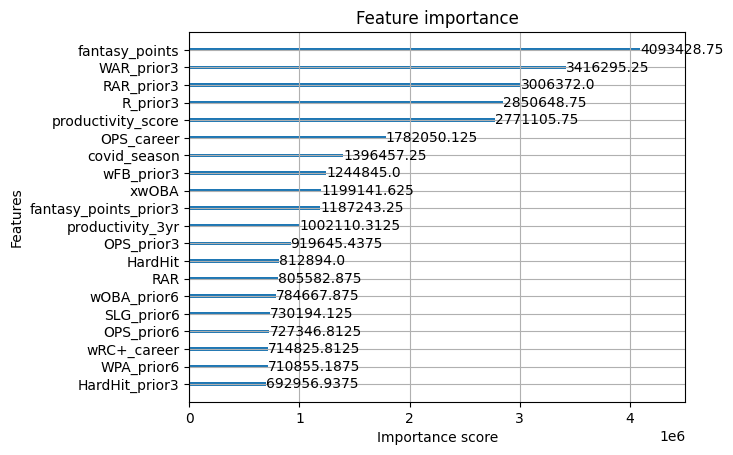

In [17]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=20)
plt.show()

In [18]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
83,Aaron Judge,1185.0,1622.405396,437.405396,437.405396,2022,30,1992
77,Juan Soto,1814.0,1585.357544,-228.642456,228.642456,2024,25,1799
131,Shohei Ohtani,1635.0,1496.161255,-138.838745,138.838745,2022,27,1483
369,Juan Soto,1406.0,1445.039795,39.039795,39.039795,2021,22,1633
38,Mookie Betts,1477.0,1395.678101,-81.321899,81.321899,2021,28,1211
...,...,...,...,...,...,...,...,...
285,Derek Hill,321.0,269.566803,-51.433197,51.433197,2023,27,48
360,Austin Hedges,226.0,264.007721,38.007721,38.007721,2024,31,172
217,Matt Duffy,300.0,254.138580,-45.861420,45.861420,2022,31,326
128,Brayan Rocchio,715.0,218.188080,-496.811920,496.811920,2023,22,124


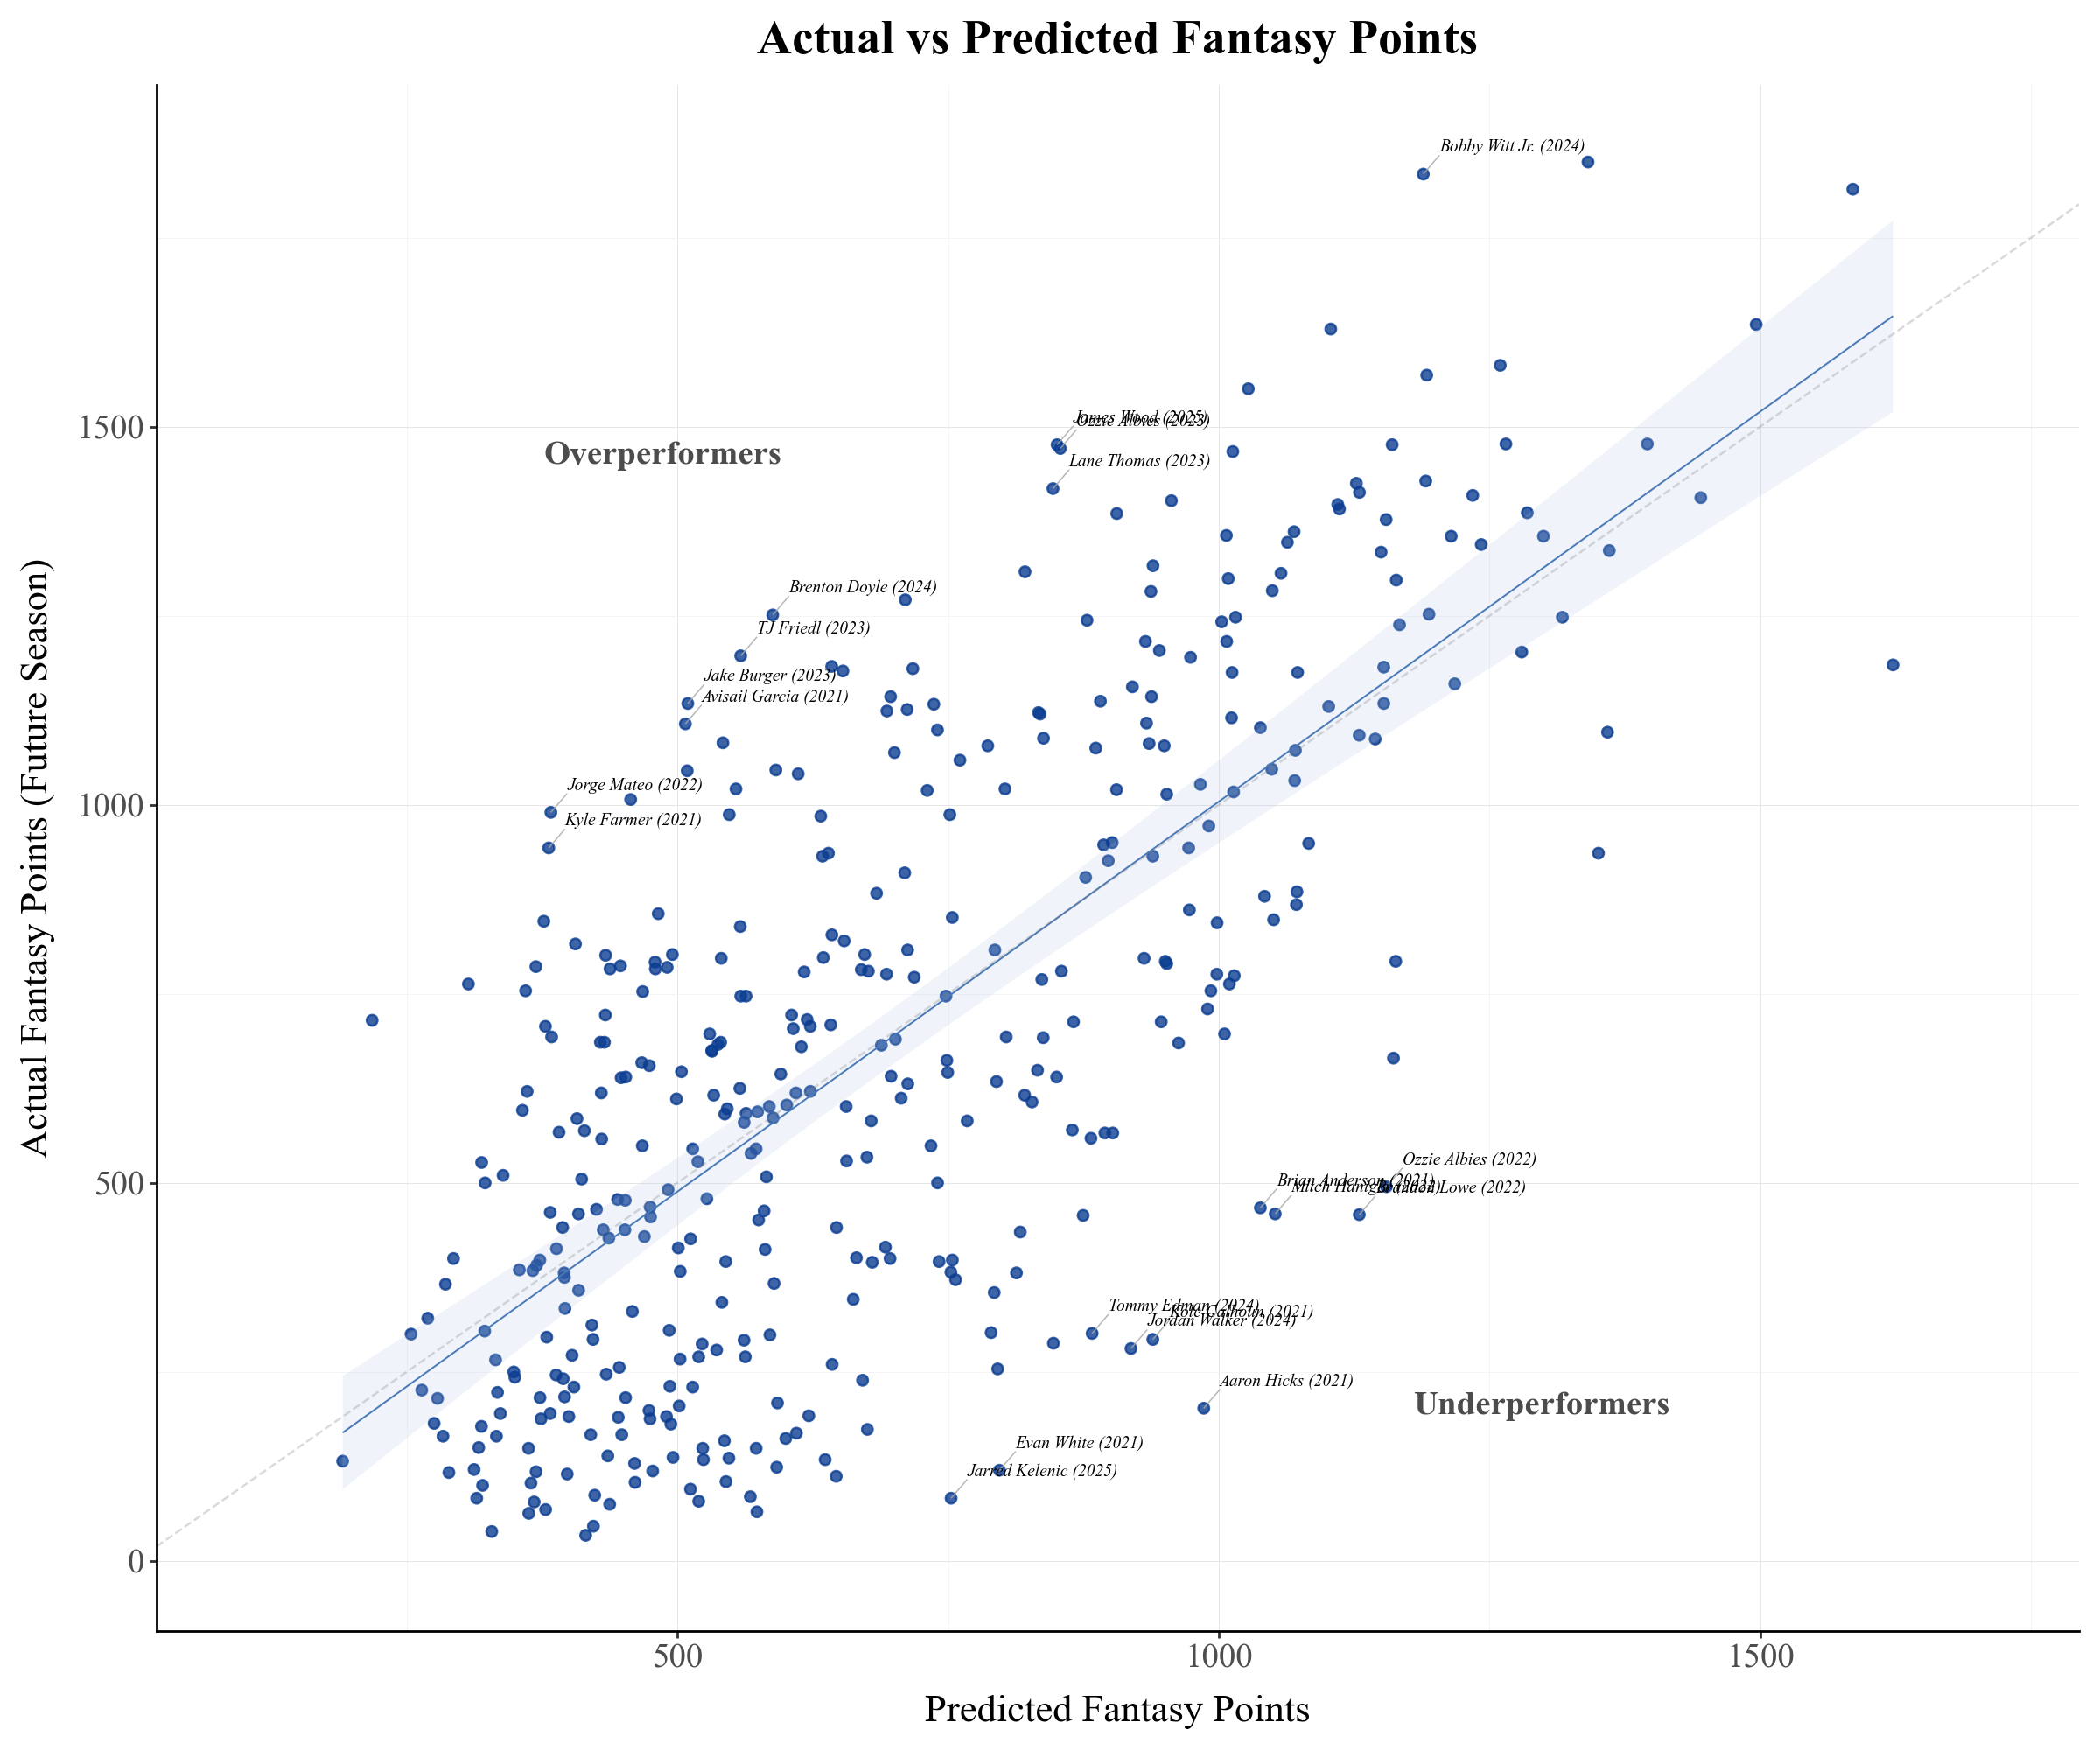

In [19]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=20,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

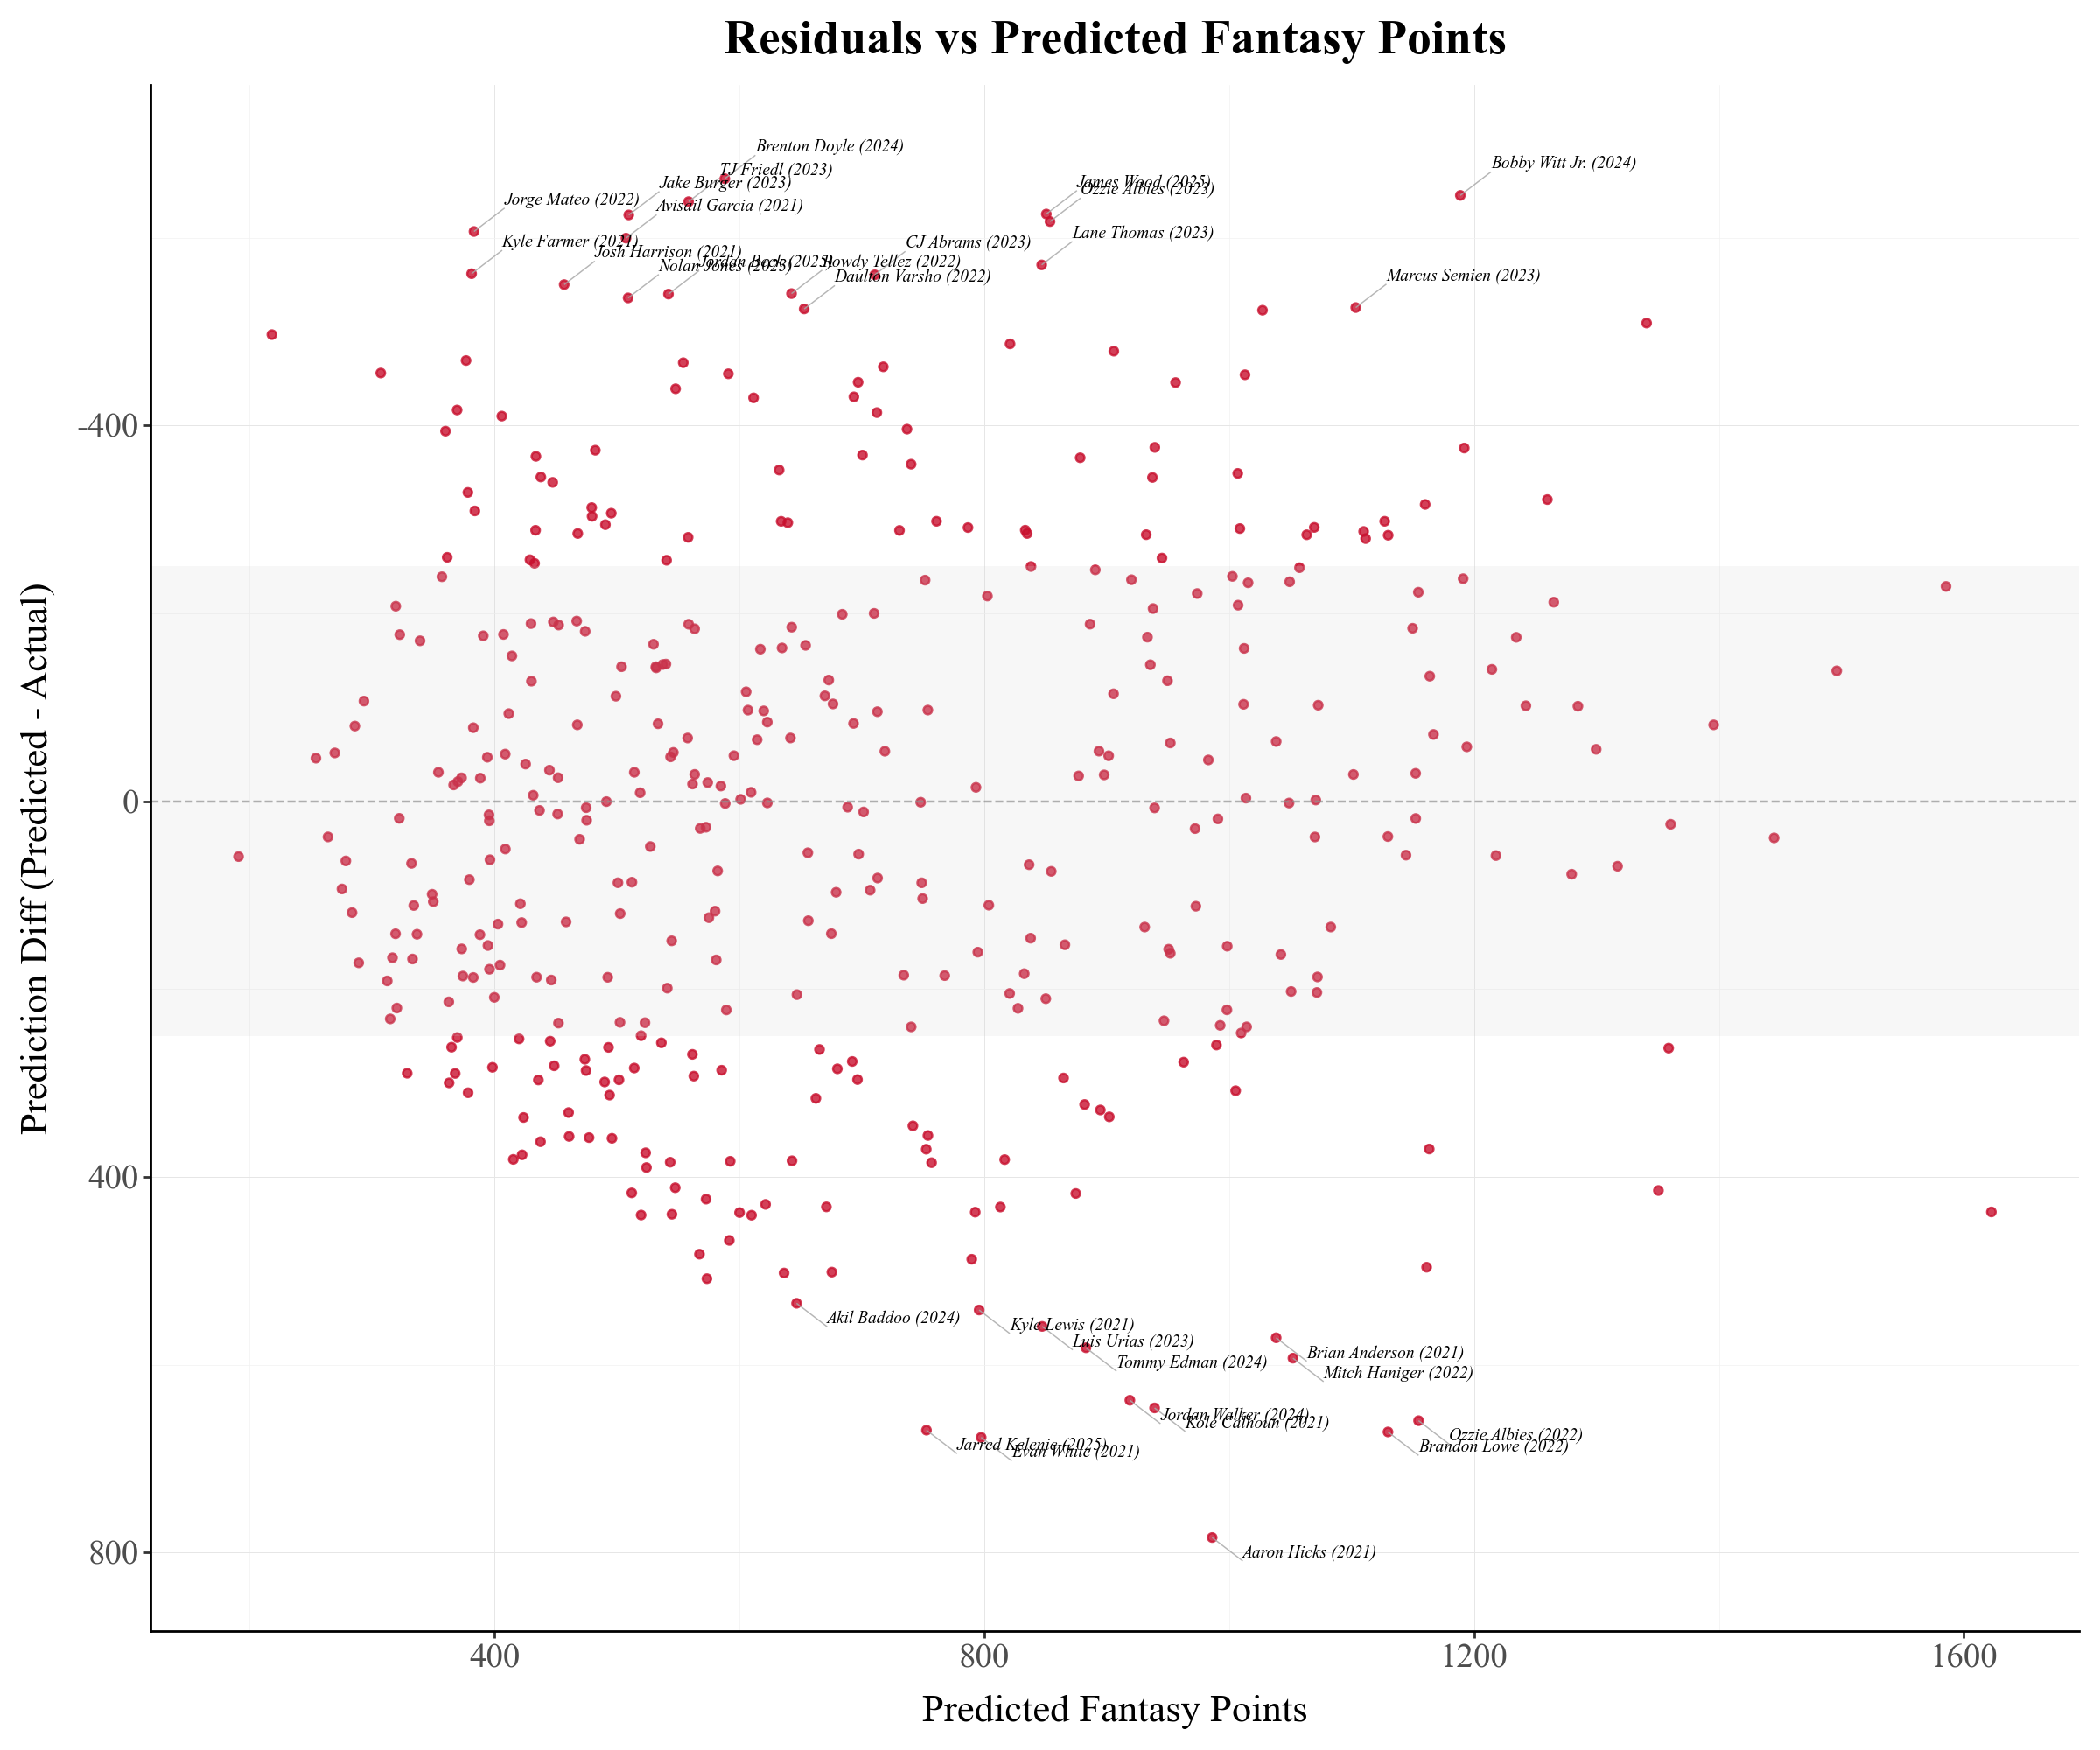

In [20]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

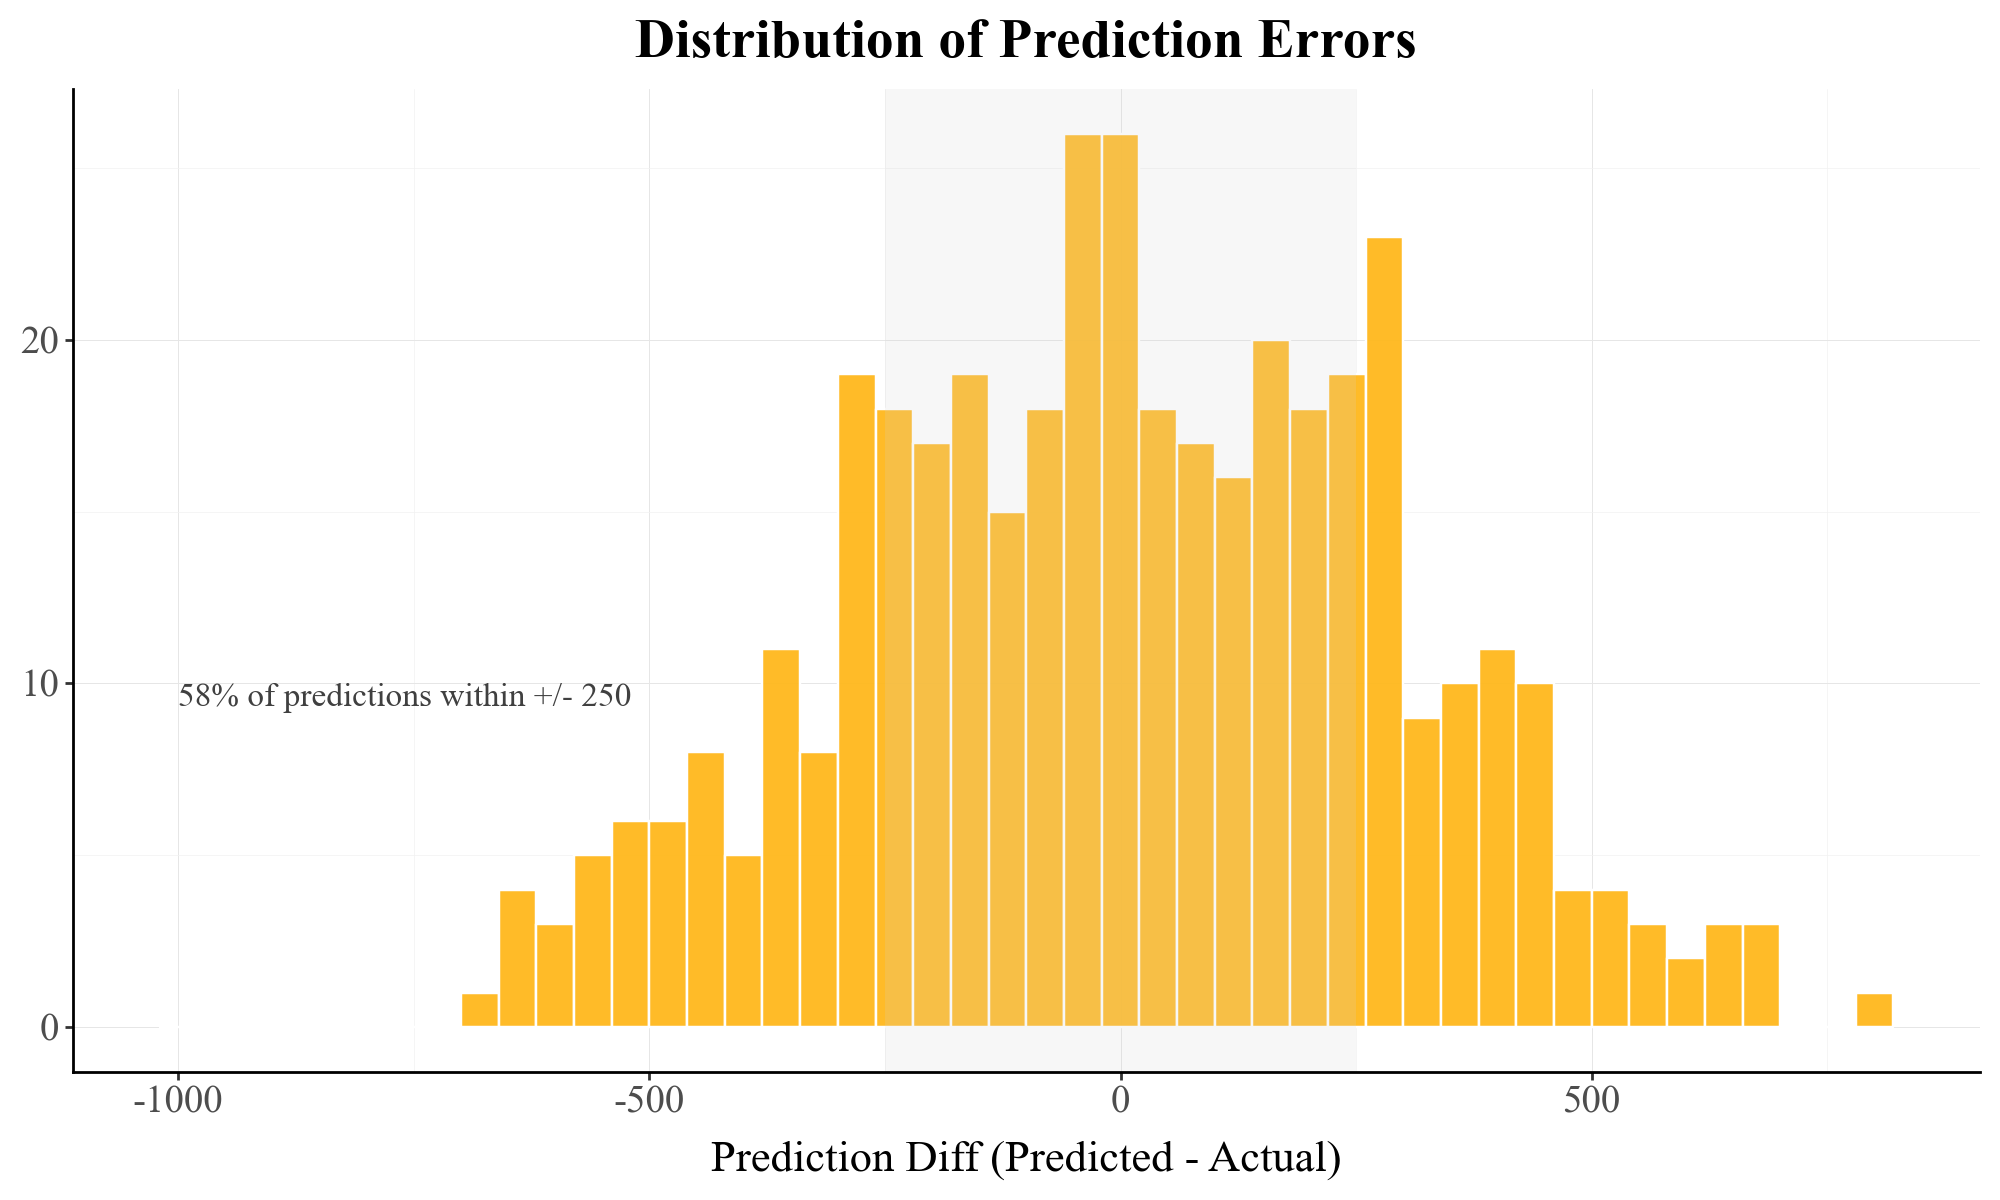

In [21]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=40,
    x_annotate=-1000,    # custom annotation position
    y_annotate=10,      # custom annotation position
)
p3.show()

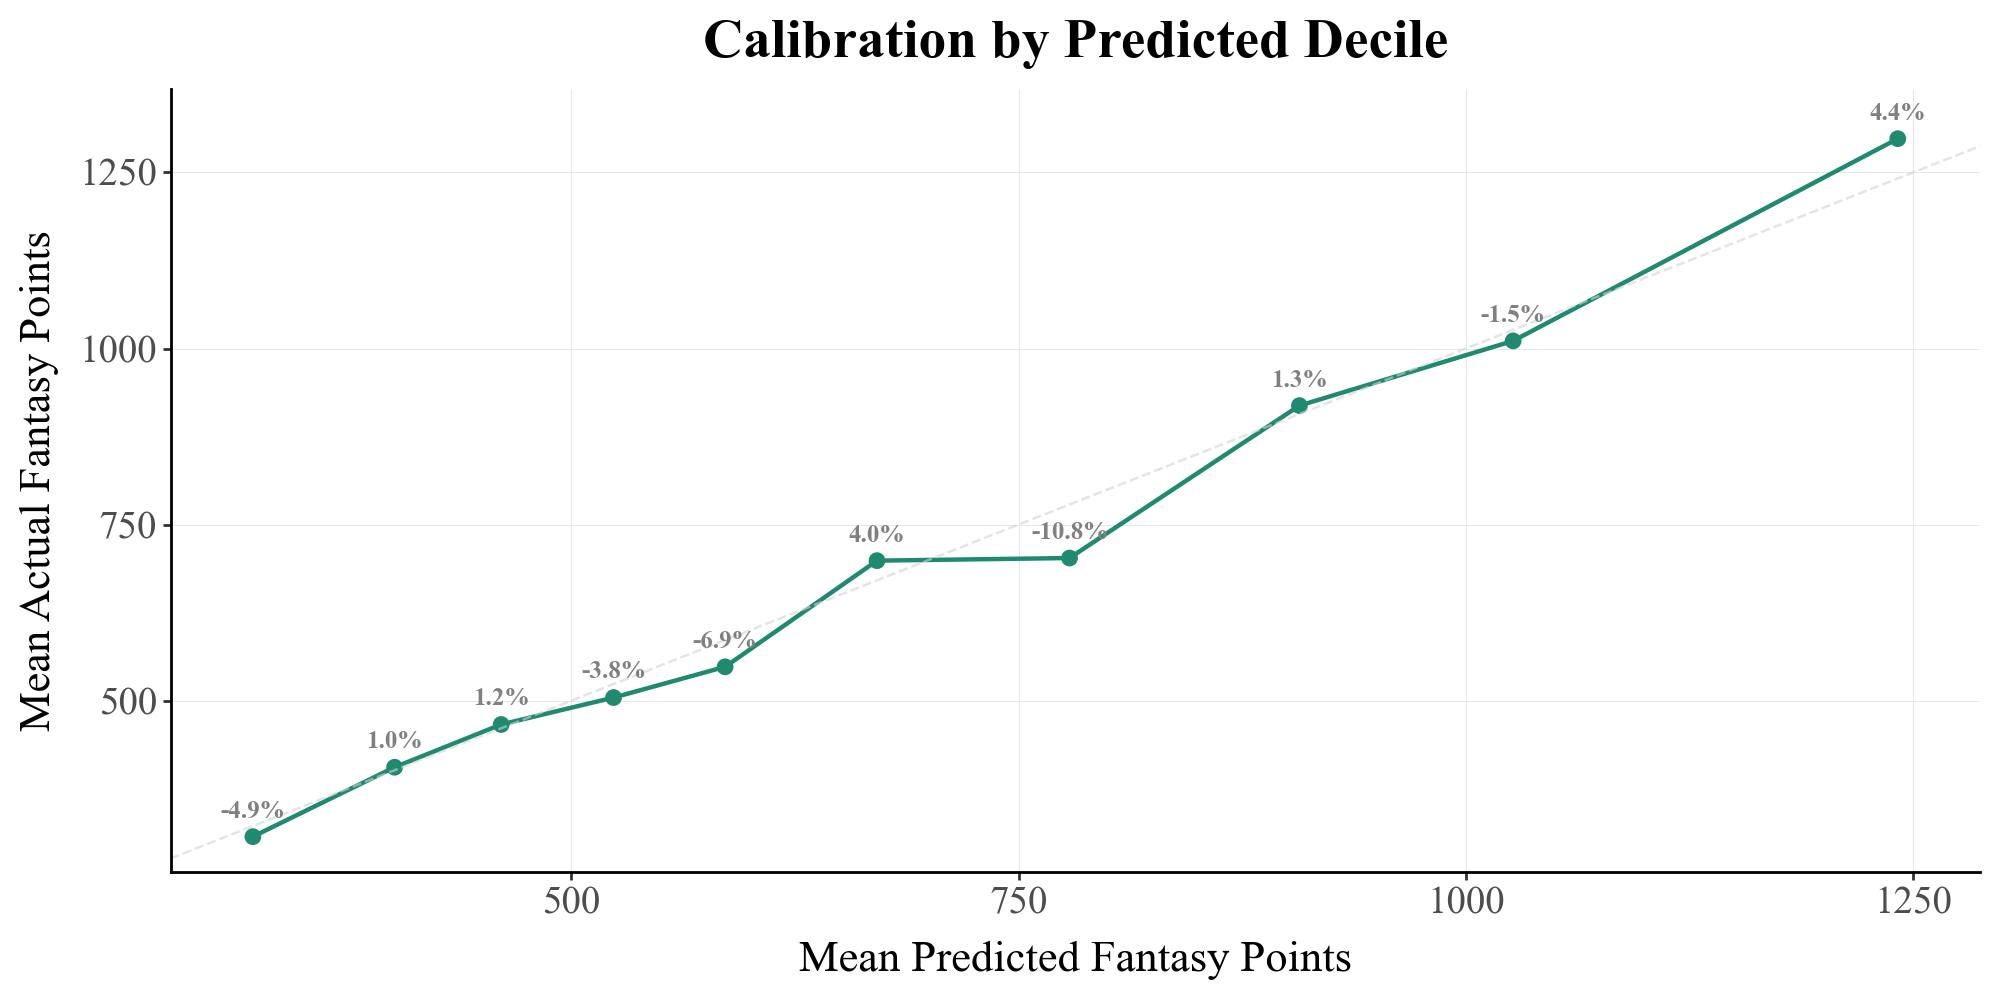

In [22]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating baseline pitching predictions

In [23]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)
# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 204.271 | MAE: 154.751 | R^2: 0.446


In [24]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
280,Luis Castillo,928.6,1067.739990,139.139990,139.139990,2020,27,422.0
151,Zack Wheeler,864.0,1032.829956,168.829956,168.829956,2021,31,1252.3
110,Carlos Rodon,252.3,919.856689,667.556689,667.556689,2022,29,1144.0
197,Lucas Giolito,805.6,879.611328,74.011328,74.011328,2021,26,982.6
152,Tarik Skubal,1197.0,864.681946,-332.318054,332.318054,2023,26,506.3
...,...,...,...,...,...,...,...,...
45,Nick Wittgren,98.0,159.862900,61.862900,61.862900,2022,31,86.0
60,Drew Hutchison,375.3,153.225555,-222.074445,222.074445,2021,30,93.3
148,Andre Scrubb,92.6,144.756683,52.156683,52.156683,2020,25,131.6
175,Richard Bleier,264.0,117.482880,-146.517120,146.517120,2020,33,74.6


# Pitching Predictions

In [25]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=25,
    random_state=62820,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 25/25 [00:22<00:00,  1.10trial/s, best loss: 202.5020466062404]
Best Parameters: {'learning_rate': 0.08546776435860781, 'max_depth': 5, 'subsample': 0.8725466612583411, 'colsample_bytree': 0.8680260026807722, 'min_child_weight': 8.015982528138222, 'reg_lambda': 1.2385638470769784, 'reg_alpha': 0.07732579587948542, 'gamma': 0.20480165911672896}
[Best trial @ val] optimized=rmse | RMSE=202.502 | MAE=154.965 | ASYM=52737.710


In [26]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=62820,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 72
[Val] RMSE: 202.502 | MAE: 154.965 | R^2: 0.438 | ASYM: 52737.710
[Test] RMSE: 202.546 | MAE: 153.332 | R^2: 0.455 | ASYM: 52630.457


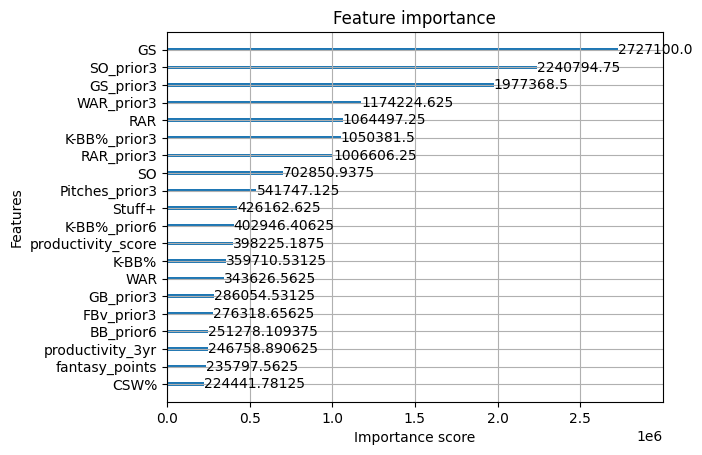

In [27]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=20)
plt.show()

In [28]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results)

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
110,Carlos Rodon,252.3,987.398376,735.098376,735.098376,2022,29,1144.0
151,Zack Wheeler,864.0,983.608398,119.608398,119.608398,2021,31,1252.3
150,Tarik Skubal,1229.3,931.863525,-297.436475,297.436475,2024,27,1197.0
152,Tarik Skubal,1197.0,903.284851,-293.715149,293.715149,2023,26,506.3
280,Luis Castillo,928.6,883.366333,-45.233667,45.233667,2020,27,422.0
...,...,...,...,...,...,...,...,...
392,Casey Lawrence,86.3,159.868729,73.568729,73.568729,2022,34,42.0
204,Yusmeiro Petit,283.0,158.170456,-124.829544,124.829544,2020,35,112.6
59,Devin Smeltzer,66.3,154.422668,88.122668,88.122668,2022,26,268.3
175,Richard Bleier,264.0,152.214691,-111.785309,111.785309,2020,33,74.6


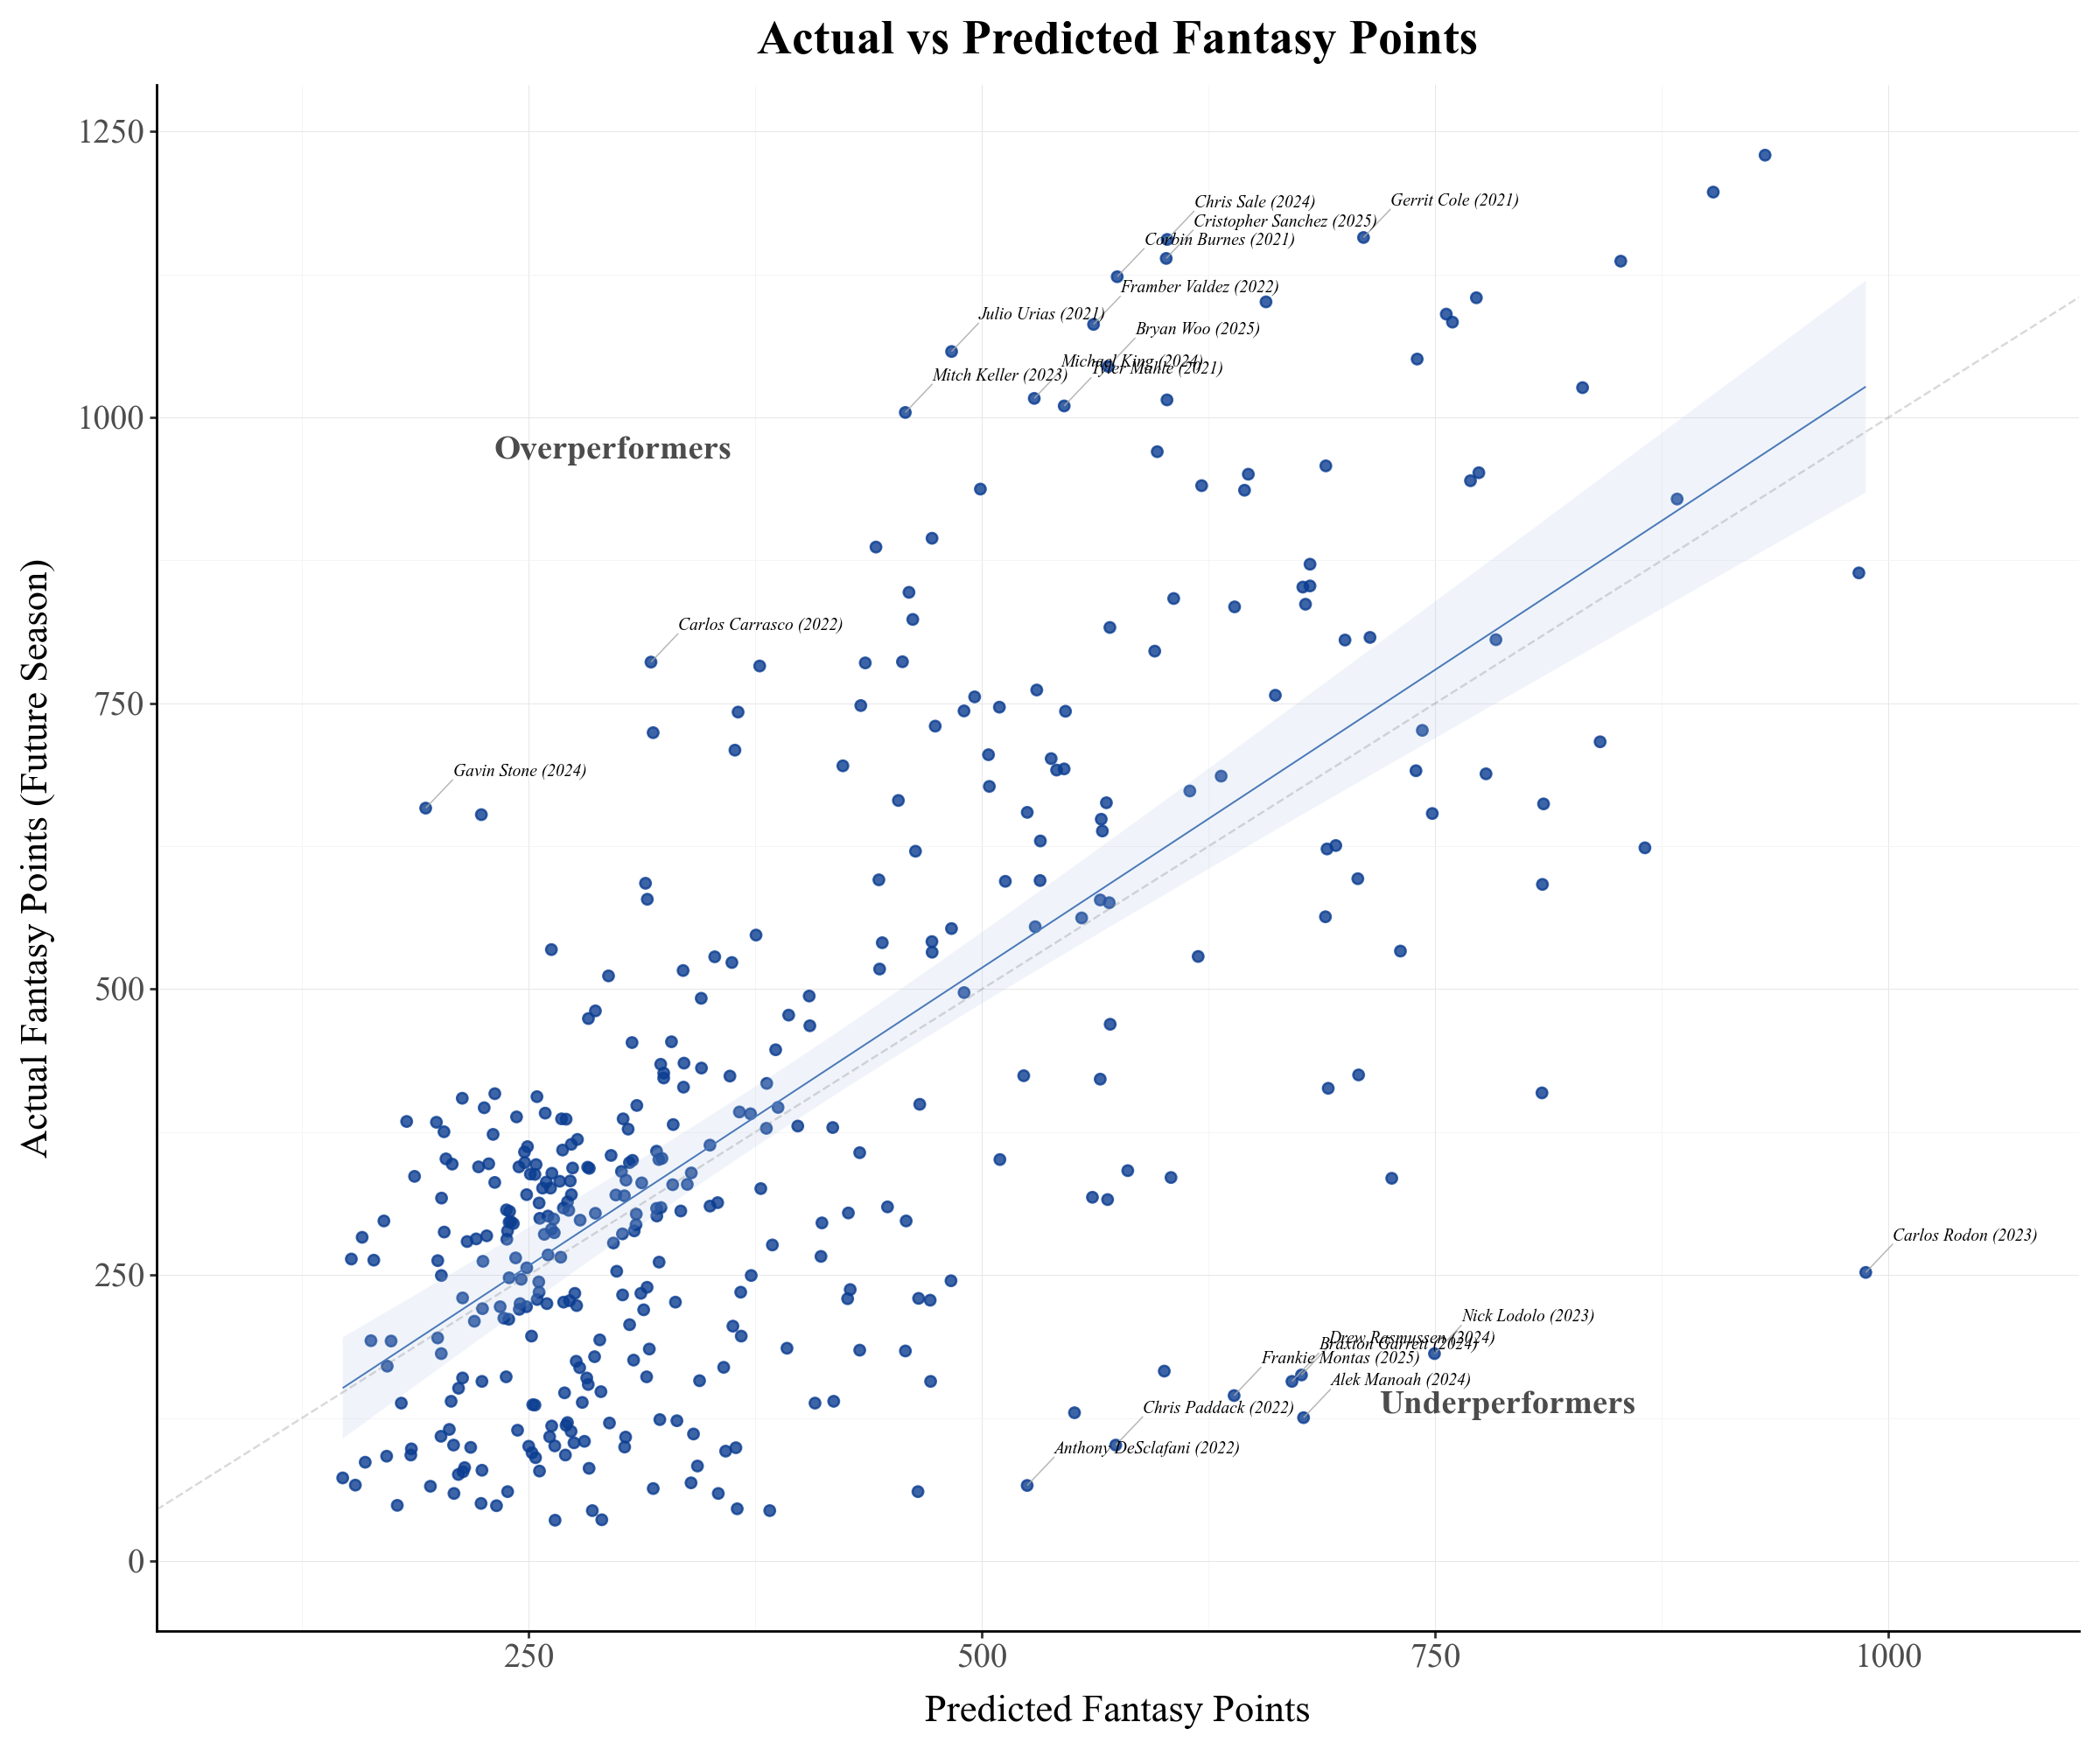

In [29]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=20,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

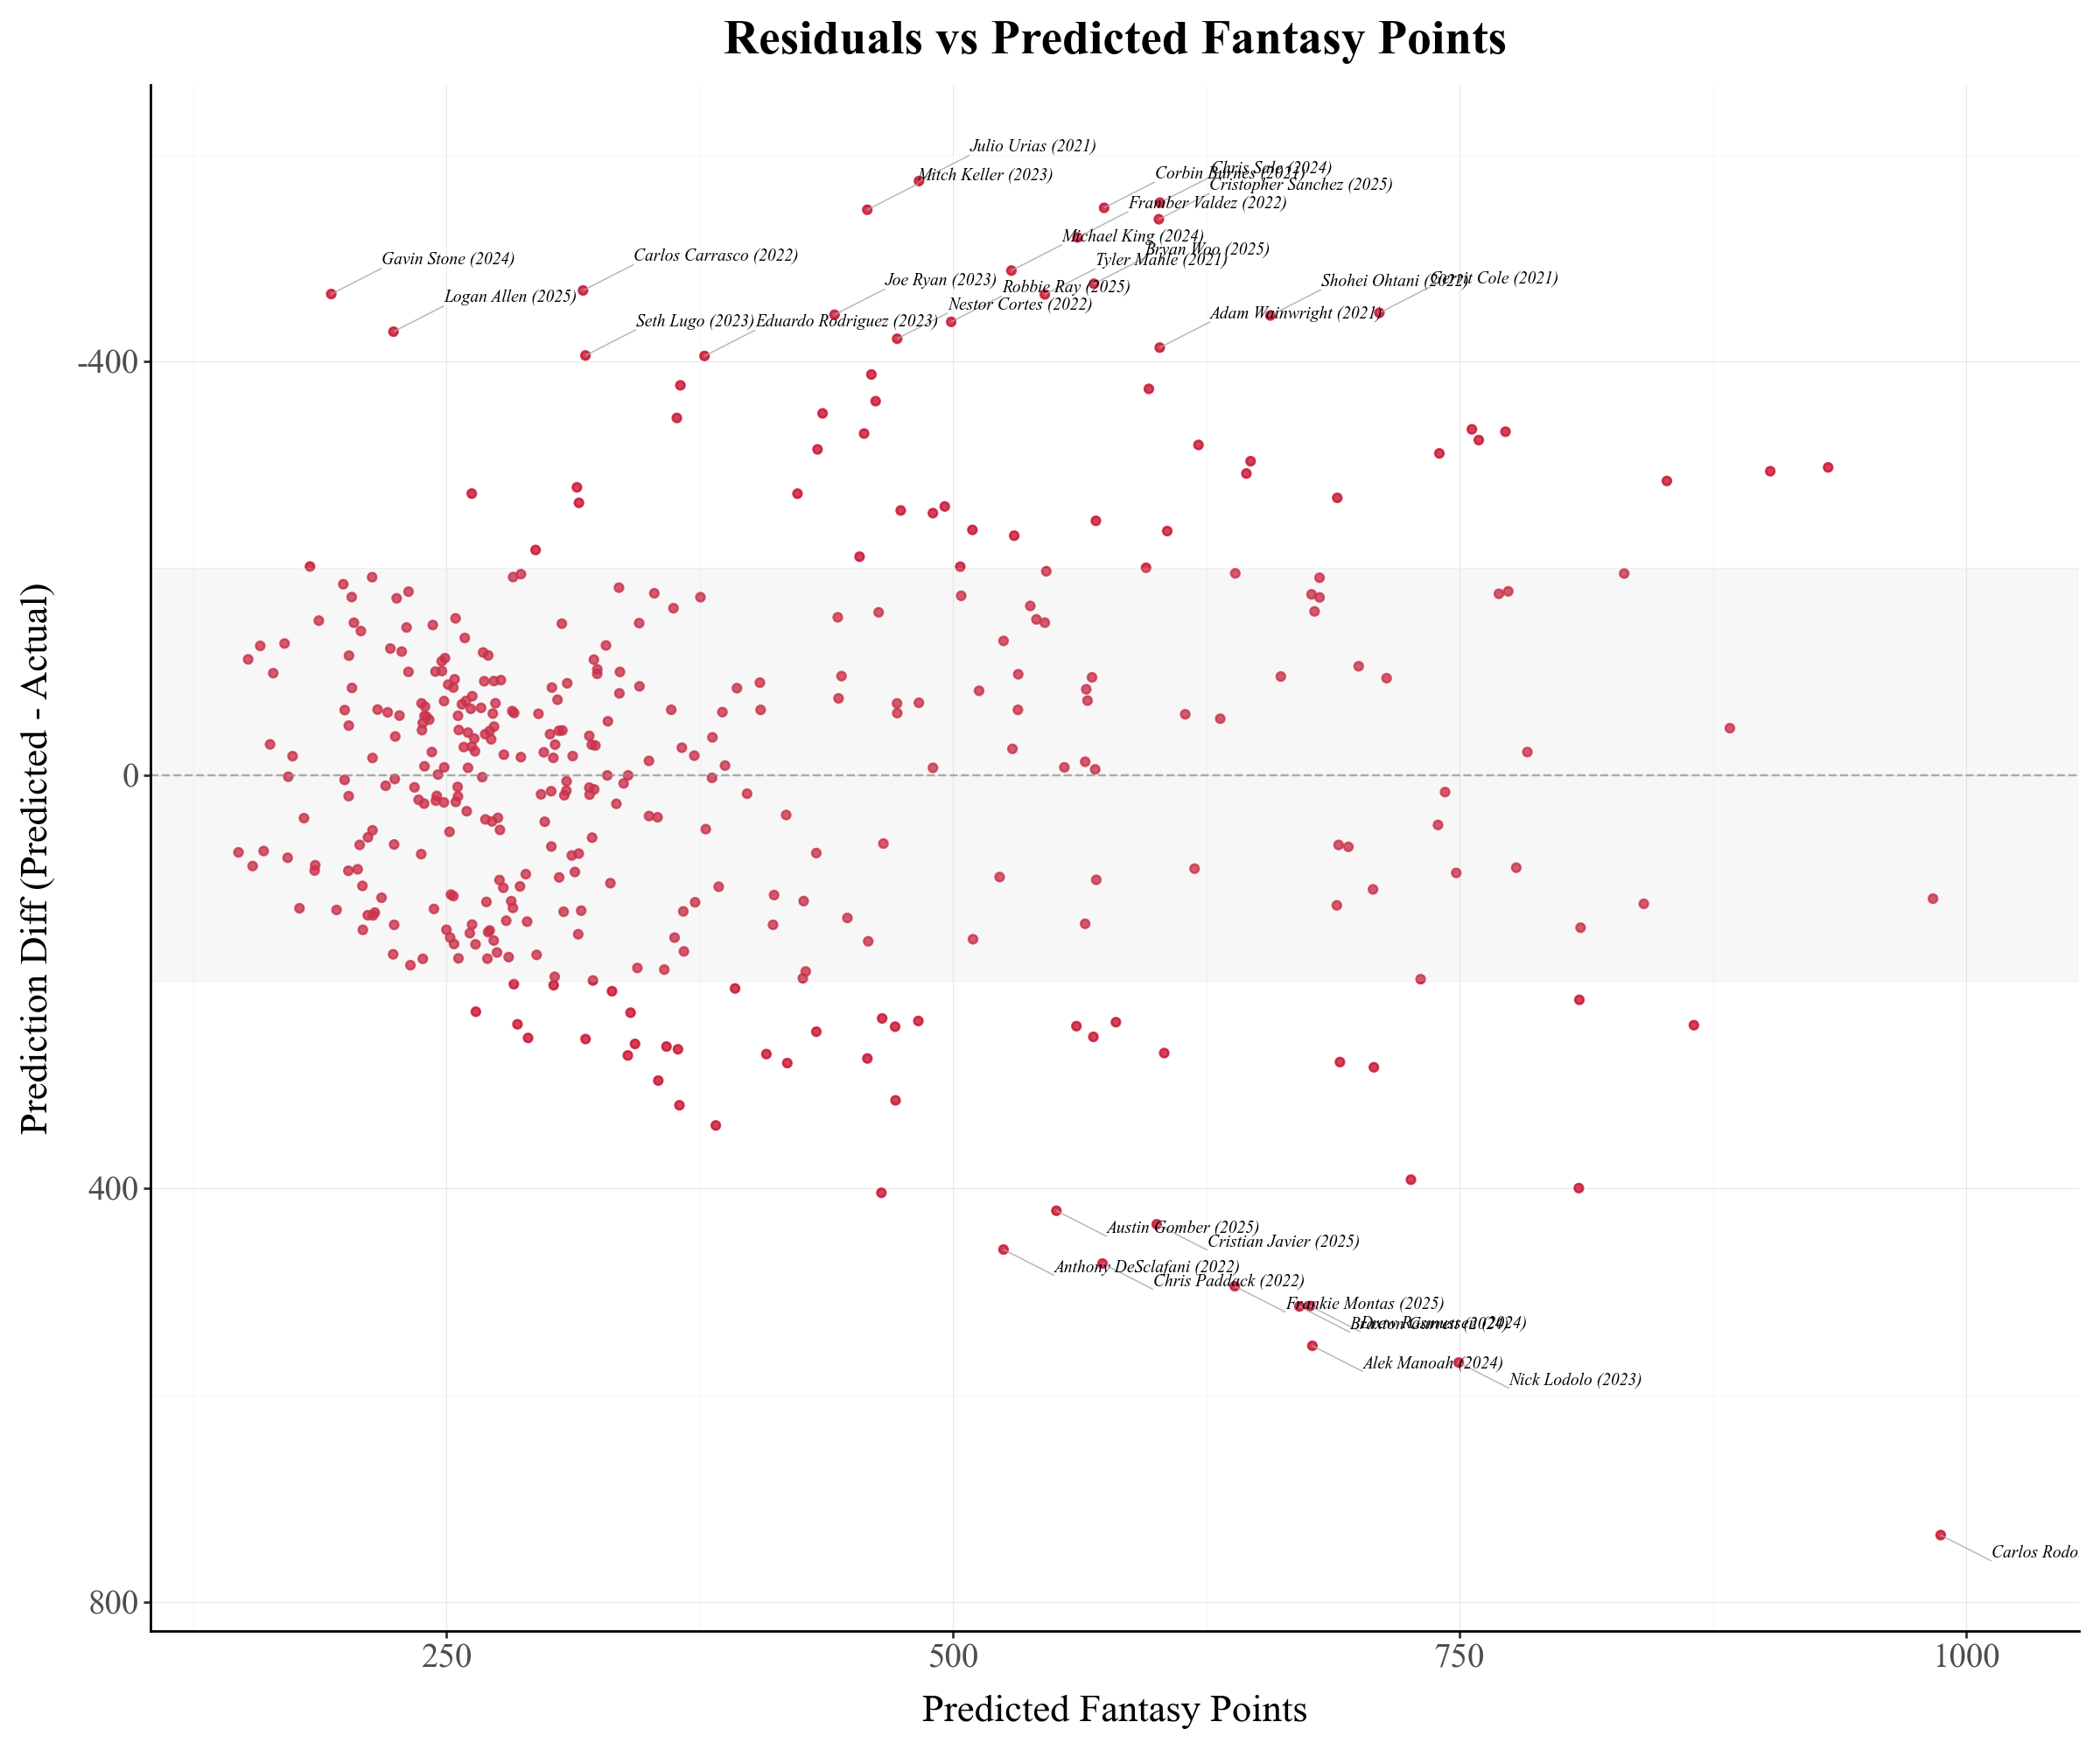

In [30]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=200,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

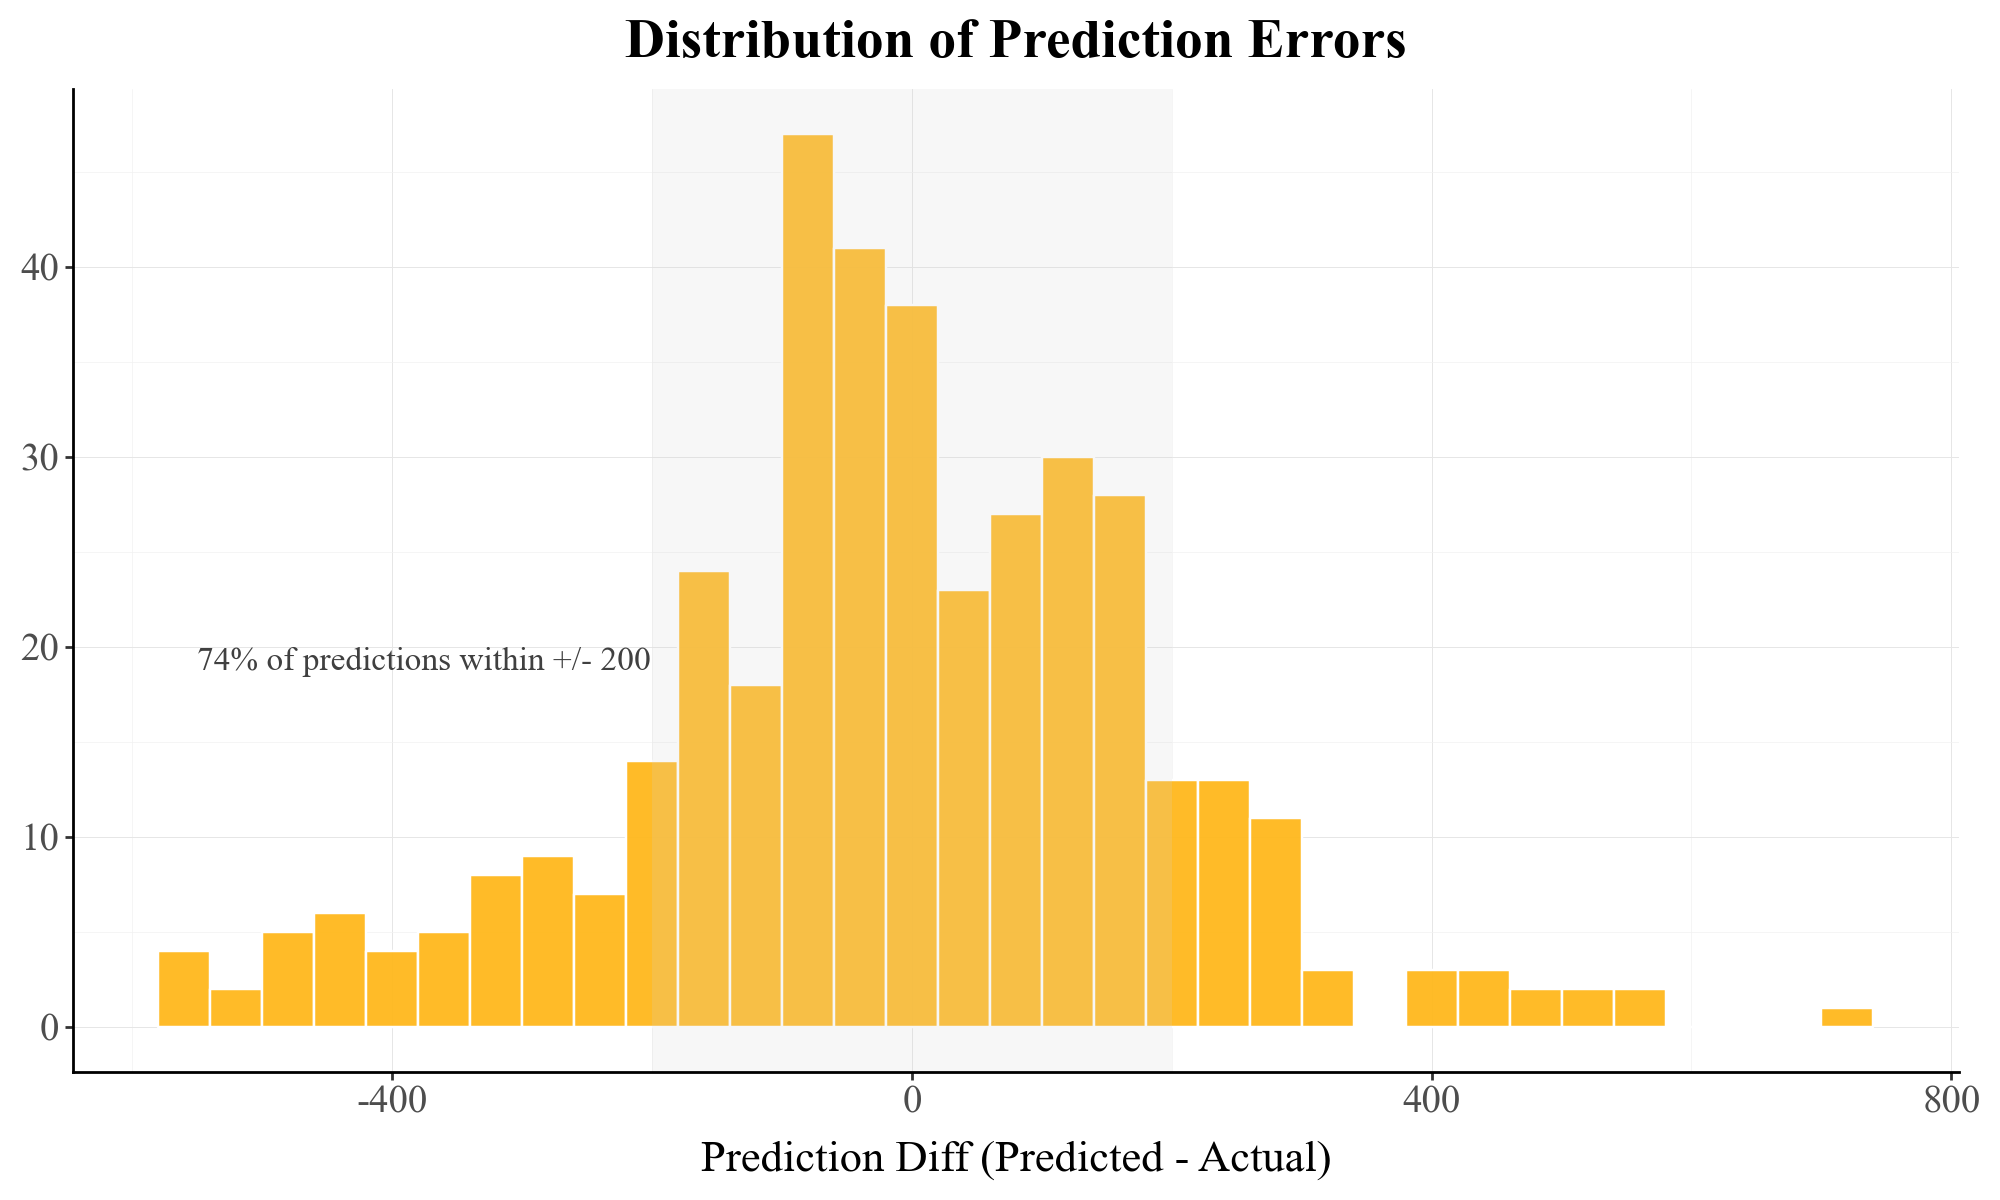

In [31]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=200,
    binwidth=40,
    x_annotate=-550,    # custom annotation position
    y_annotate=20,      # custom annotation position
)
p3.show()

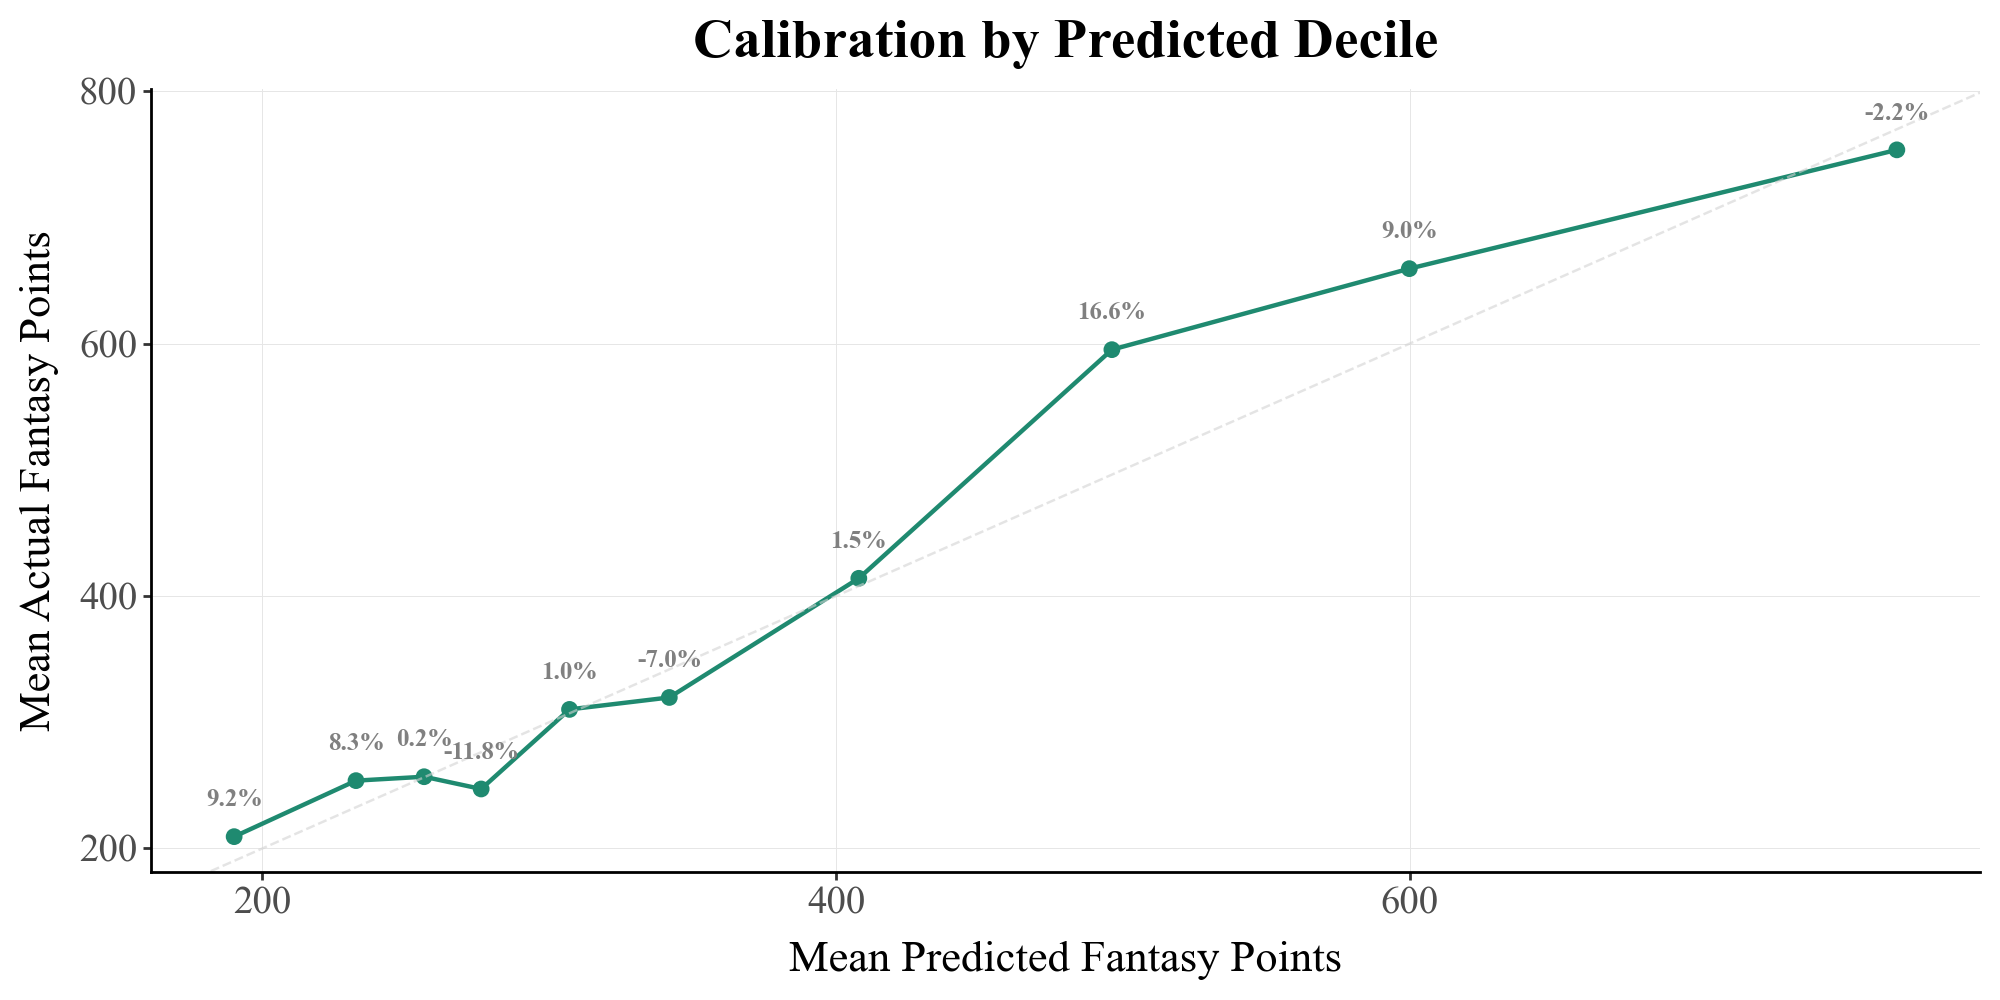

In [32]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [34]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_predictions = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_predictions = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

In [35]:
batting_pred['fantasy_points_pred'] = batting_predictions
pitching_pred['fantasy_points_pred'] = pitching_predictions

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)  

In [36]:
display(batting_pred)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,HR,R,RBI,HBP,BB,IBB,SO,GDP,GB,FB,K%,SB,AVG,OBP,SLG,OPS,BABIP,RAR,WAR,wRC+,BB/K,ISO,Spd,wFB,wSL,wCB,wCH,WPA,Contact%,Barrels,Barrel%,HardHit,wOBA,SwStr%,BsR,Soft%,Hard%,FB%,EV,HardHit%,xwOBA,GB%,HR/FB,fantasy_points,G_prior3,AB_prior3,H_prior3,1B_prior3,2B_prior3,3B_prior3,...,wSL_prior6,wCB_prior6,wCH_prior6,WPA_prior6,Contact%_prior6,Barrels_prior6,Barrel%_prior6,HardHit_prior6,wOBA_prior6,SwStr%_prior6,BsR_prior6,Soft%_prior6,Hard%_prior6,FB%_prior6,EV_prior6,HardHit%_prior6,xwOBA_prior6,GB%_prior6,HR/FB_prior6,fantasy_points_prior6,G_career,AB_career,H_career,1B_career,2B_career,3B_career,HR_career,R_career,RBI_career,BB_career,SO_career,SB_career,HBP_career,AVG_career,OBP_career,SLG_career,OPS_career,BABIP_career,ISO_career,wRC+_career,WAR_career,fantasy_points_career,covid_season,covid_impact_prior3,covid_impact_prior6,rookie_year,years_in_league,draft_year,draft_overall_pick,is_drafted,years_since_draft,overall_pick_bucket,birth_country,is_international,is_intl_undrafted,fantasy_points_delta,productivity_score,productivity_trend,productivity_3yr,fantasy_points_pred
2055,19755,2025,Shohei Ohtani,30,158,611,172,83,25,9,55,146,102,3,109,20,187,9,167,187,0.257,20,0.282,0.392,0.622,1.014,0.315,73.1,7.5,172,0.58,0.340,7.1,20.9,8.6,9.9,8.7,5.89,0.684,100,0.234,250,0.418,0.142,3.7,0.099,0.453,0.439,94.9,0.584,0.423,0.392,0.294,1933,452.0,1744.0,520.0,254.0,89.0,24.0,...,46.7,38.5,26.4,24.20,0.709,434,0.202,1175,0.403,0.136,18.4,0.105,0.427,0.402,94.1,0.546,0.412,0.399,0.280,9200,1033,3730,1050,533,192,45,280,708,669,541,1104,165,25,0.282,0.374,0.582,0.957,0.325,0.301,156,36.0,11023,False,False,True,2018.0,7.0,0,0.0,0,0.0,NaN,Japan,1,1,29.333333,2.147778,-0.400379,2.260465,1634.585327
2211,20123,2025,Juan Soto,26,160,577,152,88,20,1,43,120,105,3,127,13,137,17,198,171,0.192,38,0.263,0.396,0.525,0.921,0.270,56.7,5.8,156,0.93,0.262,5.6,16.5,5.2,5.3,6.0,5.00,0.802,81,0.181,247,0.390,0.070,2.7,0.150,0.445,0.386,93.8,0.551,0.427,0.447,0.251,1814,479.0,1721.0,474.0,266.0,83.0,6.0,...,33.9,21.9,32.6,21.98,0.814,361,0.155,1241,0.404,0.066,-8.3,0.155,0.397,0.342,93.0,0.534,0.428,0.479,0.238,8925,1096,3857,1086,627,199,16,244,775,697,896,833,95,19,0.282,0.417,0.531,0.948,0.300,0.250,158,42.3,11712,False,False,True,2018.0,7.0,0,0.0,0,0.0,NaN,Dominican Republic,1,1,51.000000,2.683432,-0.194968,2.823851,1624.049194
1375,16478,2025,Kyle Schwarber,32,162,604,145,64,23,2,56,111,132,11,108,6,197,4,139,196,0.272,10,0.240,0.365,0.563,0.928,0.253,48.1,4.9,152,0.55,0.323,4.1,34.3,-0.6,0.6,6.5,3.06,0.693,85,0.208,243,0.391,0.128,-1.1,0.154,0.453,0.480,94.3,0.596,0.402,0.341,0.286,1789,472.0,1762.0,402.0,194.0,64.0,3.0,...,7.5,17.3,16.7,11.75,0.712,344,0.177,1044,0.365,0.116,-11.1,0.157,0.414,0.455,93.2,0.537,0.380,0.372,0.261,7881,1222,4312,993,487,169,13,324,748,741,728,1450,34,46,0.230,0.346,0.501,0.847,0.261,0.271,126,20.0,11255,False,False,True,2015.0,10.0,2014,4.0,1,11.0,top10,USA,0,0,161.000000,1.747070,0.145613,1.692472,1551.557495
1712,18345,2025,Kyle Tucker,28,136,500,133,82,25,4,22,91,73,4,87,7,88,8,141,186,0.147,25,0.266,0.377,0.464,0.841,0.282,44.0,4.5,136,0.99,0.198,6.3,14.2,1.0,4.3,5.2,2.44,0.821,45,0.108,168,0.363,0.080,3.8,0.139,0.329,0.448,90.1,0.402,0.371,0.340,0.118,1349,371.0,1351.0,376.0,218.0,75.0,9.0,...,29.1,10.6,15.6,15.95,0.821,236,0.108,959,0.371,0.086,17.0,0.123,0.366,0.452,90.5,0.439,0.376,0.347,0.146,7068,769,2741,748,421,160,20,147,456,490,363,498,119,13,0.273,0.358,0.507,0.865,0.284,0.234,138,25.4,7349,False,False,True,2018.0,7.0,2015,5.0,1,10.0,top10,USA,0,0,72.666667,1.720663,0.534106,1.765424,1443.367676
1204,15640,2025,Aaron Judge,33,152,541,179,94,30,2,53,137,114,7,124,36,160,16,132,180,0.236,12,0.331,0.457,0.688,1.144,0.376,99.0,10.1,204,0.78,0.357,4.6,41.2,9.5,-0.1,8.9,5.61,0.676,96,0.247,226,0.463,0.141,-4.1,0.098,0.456,0.464,95.4,0.582,0.458,0.340,0.294,1951,416.0,1467.0,457.0,224.0,82.0,3.0,...,65.7,14.4,24.1,28.26,0.703,451,0.239,1125,0.441,0.126,-6.0,0.084,0.477,0.437,95.

In [38]:
display(pitching_pred)

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,xERA,ERA,IP,TBF,H,ER,HR,BB,SO,GB,FB,AVG,WHIP,BABIP,K/BB,K-BB%,FIP,SwStr%,CSW%,HR/FB,FBv,FB%,wFB,wSL,wCB,wCH,WPA,RAR,Swing%,K%,BB%,SIERA,Soft%,Barrel%,HardHit,Hard%,Pitching+,Location+,Stuff+,LOB%,GB%,fantasy_points,G_prior3,GS_prior3,Pitches_prior3,Strikes_prior3,W_prior3,WAR_prior3,xERA_prior3,ERA_prior3,...,FIP_prior6,SwStr%_prior6,CSW%_prior6,HR/FB_prior6,FBv_prior6,FB%_prior6,wFB_prior6,wSL_prior6,wCB_prior6,wCH_prior6,WPA_prior6,RAR_prior6,Swing%_prior6,K%_prior6,BB%_prior6,SIERA_prior6,Soft%_prior6,Barrel%_prior6,HardHit_prior6,Hard%_prior6,Pitching+_prior6,Location+_prior6,Stuff+_prior6,LOB%_prior6,GB%_prior6,fantasy_points_prior6,G_career,GS_career,IP_career,TBF_career,W_career,SO_career,BB_career,HR_career,ER_career,ERA_career,FIP_career,WHIP_career,K/BB_career,K-BB%_career,WAR_career,fantasy_points_career,covid_season,covid_impact_prior3,covid_impact_prior6,rookie_year,years_in_league,draft_year,draft_overall_pick,is_drafted,years_since_draft,overall_pick_bucket,birth_country,is_international,is_intl_undrafted,fantasy_points_delta,productivity_score,productivity_trend,productivity_3yr,fantasy_points_pred
3106,27463,2025,Garrett Crochet,26,32,32,3151,2114,18,5.8,2.91,2.59,205.1,814,165,59,24,46,255,243,170,0.216,1.03,0.290,5.54,0.257,2.89,0.137,0.290,0.141,96.3,0.338,3.3,13.8,0.0,2.2,4.93,52.8,0.515,0.313,0.057,2.86,0.177,0.073,190,0.324,112,99,116,0.843,0.483,1293.3,77.0,64.0,5838.0,3911.0,24.0,10.3,2.99,3.02,...,2.86,0.142,0.295,0.122,96.8,0.358,27.8,11.3,0.0,4.6,7.35,109.5,0.507,0.318,0.069,2.96,0.177,0.076,401,0.325,113.0,100.0,114.0,0.786,0.458,2637.3,136,64,424.1,1725,27,549,119,45,139,2.95,2.86,1.09,4.61,0.249,11.9,2637.3,False,False,True,2020.0,5.0,2017,1014.0,1,8.0,200+,USA,0,0,535.300000,1.913166,0.439566,1.350203,969.783203
1563,17295,2025,Framber Valdez,31,31,31,2898,1863,13,4.0,3.74,3.66,192.0,802,171,78,15,68,187,313,122,0.235,1.24,0.297,2.75,0.148,3.37,0.115,0.285,0.123,94.3,0.228,12.2,0.0,-0.2,-0.5,1.49,37.9,0.470,0.233,0.085,3.66,0.124,0.067,250,0.346,109,99,108,0.729,0.586,968.0,90.0,90.0,8465.0,5395.0,40.0,12.1,3.83,3.35,...,3.36,0.112,0.289,0.141,94.0,0.201,48.7,0.0,46.1,8.5,9.75,191.4,0.456,0.238,0.080,3.52,0.133,0.065,1201,0.335,107.0,100.0,106.0,0.743,0.615,5090.0,188,166,1080.2,4483,81,1053,389,87,404,3.36,3.51,1.20,2.71,0.148,20.5,5592.6,False,False,True,2018.0,7.0,0,0.0,0,0.0,NaN,Dominican Republic,1,1,-9.766667,1.007284,-0.036383,1.090309,934.221008
650,12768,2025,Sonny Gray,35,32,32,2724,1801,14,3.6,3.90,4.28,180.2,753,185,86,25,38,201,222,173,0.260,1.23,0.329,5.29,0.216,3.39,0.121,0.308,0.145,92.0,0.342,-10.0,8.1,6.7,-5.6,0.32,33.8,0.472,0.267,0.050,3.29,0.179,0.098,207,0.341,101,102,96,0.696,0.439,955.6,92.0,92.0,8037.0,5264.0,35.0,12.8,3.74,3.63,...,3.29,0.115,0.300,0.119,92.5,0.328,13.9,32.0,20.2,-9.1,6.36,182.5,0.456,0.268,0.070,3.57,0.173,0.072,859,0.317,102.0,100.0,99.0,0.724,0.454,4571.0,263,256,1427.0,5961,92,1506,468,156,606,3.82,3.57,1.22,3.22,0.174,29.0,7441.0,False,False,True,2013.0,12.0,2008,821.0,1,17.0,200+,USA,0,0,-6.733333,0.780082,-0.049763,0.833550,866.875488
1963,19291,2025,Zac Gallen,29,33,33,3135,1975,13,1.1,4.28,4.83,192.0,813,176,103,31,66,175,246,213,0.237,1.26,0.270,2.65,0.134,4.50,0.095,0.276,0.146,93.6,0.378,4.8,-3.0,-2.2,2.7,-1.46,10.7,0.446,0.215,0.081,4.24,0.127,0.097,244,0.352,101,105,93,0.676,0.436,857.0,95.0,95.0,8894.0,5628.0,44.0,9.0,4.15,3.99,...,3.66,0.103,0.282,0.122,93.7,0.357,54.6,-18.4,27.1,14.1,7.98,153.1,0.453,0.253,0.076,3.81,0.130,0.084,1044,0.350,104.0,104.0,98.0,0.740,0.442,4860.3,176,176,1007.1,4142,66,1060,324,117,401,3.58,3.65,1.16,3.27,0.178,17.5,5328.3,False,False,True,2019.0,6.0,2016,106.0,1,9.0,101-200,USA,0,0,-73.333333,1.019025,-0.003934,1.198265,841.486633
414,10310,2025,Zack Wheeler,35,24,24,2394,1549,10,4.0,2.48,2.71,149.2,585,107,45,19,33,195,139,134,0.197,0.94,0.267,5.91,0.277,3.00,0.145,0.289,0.142,95.9,0.385,10.8,9.8,3.0,0.0,3.16,37.0,0.501,0.333,0.056,2.73,0.181,0.072,119,0.246

In [39]:
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

In [40]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,HR,R,RBI,HBP,BB,IBB,SO,GDP,GB,FB,K%,SB,AVG,OBP,SLG,OPS,BABIP,RAR,WAR,wRC+,BB/K,ISO,Spd,wFB,wSL,wCB,wCH,WPA,Contact%,Barrels,Barrel%,HardHit,wOBA,SwStr%,BsR,Soft%,Hard%,FB%,EV,HardHit%,xwOBA,GB%,HR/FB,fantasy_points,G_prior3,AB_prior3,H_prior3,1B_prior3,2B_prior3,3B_prior3,...,Barrels_prior6,Barrel%_prior6,HardHit_prior6,wOBA_prior6,SwStr%_prior6,BsR_prior6,Soft%_prior6,Hard%_prior6,FB%_prior6,EV_prior6,HardHit%_prior6,xwOBA_prior6,GB%_prior6,HR/FB_prior6,fantasy_points_prior6,G_career,AB_career,H_career,1B_career,2B_career,3B_career,HR_career,R_career,RBI_career,BB_career,SO_career,SB_career,HBP_career,AVG_career,OBP_career,SLG_career,OPS_career,BABIP_career,ISO_career,wRC+_career,WAR_career,fantasy_points_career,covid_season,covid_impact_prior3,covid_impact_prior6,rookie_year,years_in_league,draft_year,draft_overall_pick,is_drafted,years_since_draft,overall_pick_bucket,birth_country,is_international,is_intl_undrafted,fantasy_points_delta,productivity_score,productivity_trend,productivity_3yr,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
448,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,19.0,48.0,67.0,6.0,64.0,2.0,83.0,4.0,75.0,113.0,0.214,4.0,0.243,0.376,0.470,0.846,0.264,28.5,2.9,137.0,0.77,0.227,4.3,18.7,-4.2,-1.0,3.6,1.45,0.778,32.0,0.136,121.0,0.366,0.094,0.4,0.119,0.379,0.481,91.3,0.515,0.376,0.319,0.168,857.0,308.0,1032.0,233.0,116.0,44.0,3.0,...,222.0,0.140,733.0,0.349,0.098,-2.8,0.125,0.387,0.471,90.7,0.462,0.368,0.340,0.186,5725.0,975.0,3191.0,734.0,377.0,137.0,9.0,211.0,579.0,595.0,595.0,938.0,18.0,50.0,0.230,0.357,0.477,0.833,0.252,0.247,127.0,23.1,8490.0,False,False,True,2015.0,10.0,2009,1235.0,1.0,16.0,200+,USA,0.0,0.0,-80.666667,0.741349,0.130698,0.870915,829.097412,max,muncy,LAD,3B,899.0
449,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,19.0,48.0,67.0,6.0,64.0,2.0,83.0,4.0,75.0,113.0,0.214,4.0,0.243,0.376,0.470,0.846,0.264,28.5,2.9,137.0,0.77,0.227,4.3,18.7,-4.2,-1.0,3.6,1.45,0.778,32.0,0.136,121.0,0.366,0.094,0.4,0.119,0.379,0.481,91.3,0.515,0.376,0.319,0.168,857.0,308.0,1032.0,233.0,116.0,44.0,3.0,...,222.0,0.140,733.0,0.349,0.098,-2.8,0.125,0.387,0.471,90.7,0.462,0.368,0.340,0.186,5725.0,975.0,3191.0,734.0,377.0,137.0,9.0,211.0,579.0,595.0,595.0,938.0,18.0,50.0,0.230,0.357,0.477,0.833,0.252,0.247,127.0,23.1,8490.0,False,False,True,2015.0,10.0,2009,1235.0,1.0,16.0,200+,USA,0.0,0.0,-80.666667,0.741349,0.130698,0.870915,829.097412,max,muncy,ATH,"2B,3B,SS",649.0
450,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,9.0,17.0,23.0,3.0,10.0,0.0,68.0,1.0,62.0,47.0,0.309,1.0,0.214,0.259,0.379,0.638,0.269,-3.7,-0.4,72.0,0.15,0.165,1.6,-2.5,1.1,-2.8,-1.2,-1.01,0.703,14.0,0.101,45.0,0.277,0.148,-0.2,0.223,0.252,0.343,87.1,0.324,0.269,0.453,0.191,339.0,63.0,206.0,44.0,28.0,7.0,0.0,...,14.0,0.101,45.0,0.277,0.148,-0.2,0.223,0.252,0.343,87.1,0.324,0.269,0.453,0.191,339.0,63.0,206.0,44.0,28.0,7.0,0.0,9.0,17.0,23.0,10.0,68.0,1.0,3.0,0.214,0.259,0.379,0.638,0.269,0.165,72.0,-0.4,339.0,False,False,True,0.0,0.0,0,0.0,0.0,0.0,NaN,Unknown,0.0,0.0,226.000000,0.700413,0.000000,0.700413,607.845032,max,muncy,LAD,3B,899.0
451,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,9.0,17.0,23.0,3.0,10.0,0.0,68.0,1.0,62.0,47.0,0.309,1.0,0.214,0.259,0.379,0.638,0.269,-3.7,-0.4,72.0,0.15,0.165,1.6,-2.5,1.1,-2.8,-1.2,-1.01,0.703,14.0,0.101,45.0,0.277,0.148,-0.2,0.223,0.252,0.343,87.1,0.324,0.269,0.453,0.191,339.0,63.0,206.0,44.0,28.0,7.0,0.0,...,14.0,0.101,45.0,0.277,0.148,-0.2,0.223,0.252,0.343,87.1,0.324,0.269,0.453,0.191,339.0,63.0,206.0,44.0,28.0,7.0,0.0,9.0,17.0,23.0,10.0,68.0,1.0,3.0,0.214,0.259,0.379,0.638,0.269,0.165,72.0,-0.4,339.0,False,False,True,0.0,0.0,0,0.0,0.0,0.0,NaN,Unknown,0.0,0.0,226.000000,0.700413,0.000000,0.700413,607.845032,max,muncy,ATH,"2B,3B,SS",649.0


In [41]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

display(batting_final)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,HR,R,RBI,HBP,BB,IBB,SO,GDP,GB,FB,K%,SB,AVG,OBP,SLG,OPS,BABIP,RAR,WAR,wRC+,BB/K,ISO,Spd,wFB,wSL,wCB,wCH,WPA,Contact%,Barrels,Barrel%,HardHit,wOBA,SwStr%,BsR,Soft%,Hard%,FB%,EV,HardHit%,xwOBA,GB%,HR/FB,fantasy_points,G_prior3,AB_prior3,H_prior3,1B_prior3,2B_prior3,3B_prior3,...,Barrels_prior6,Barrel%_prior6,HardHit_prior6,wOBA_prior6,SwStr%_prior6,BsR_prior6,Soft%_prior6,Hard%_prior6,FB%_prior6,EV_prior6,HardHit%_prior6,xwOBA_prior6,GB%_prior6,HR/FB_prior6,fantasy_points_prior6,G_career,AB_career,H_career,1B_career,2B_career,3B_career,HR_career,R_career,RBI_career,BB_career,SO_career,SB_career,HBP_career,AVG_career,OBP_career,SLG_career,OPS_career,BABIP_career,ISO_career,wRC+_career,WAR_career,fantasy_points_career,covid_season,covid_impact_prior3,covid_impact_prior6,rookie_year,years_in_league,draft_year,draft_overall_pick,is_drafted,years_since_draft,overall_pick_bucket,birth_country,is_international,is_intl_undrafted,fantasy_points_delta,productivity_score,productivity_trend,productivity_3yr,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a.j.,vukovich,ARI,"3B,LF,CF",64.0
1,15640.0,2025.0,Aaron Judge,33.0,152.0,541.0,179.0,94.0,30.0,2.0,53.0,137.0,114.0,7.0,124.0,36.0,160.0,16.0,132.0,180.0,0.236,12.0,0.331,0.457,0.688,1.144,0.376,99.0,10.1,204.0,0.78,0.357,4.6,41.2,9.5,-0.1,8.9,5.61,0.676,96.0,0.247,226.0,0.463,0.141,-4.1,0.098,0.456,0.464,95.4,0.582,0.458,0.340,0.294,1951.0,416.0,1467.0,457.0,224.0,82.0,3.0,...,451.0,0.239,1125.0,0.441,0.126,-6.0,0.084,0.477,0.437,95.9,0.595,0.454,0.352,0.313,8912.0,1145.0,4105.0,1205.0,627.0,203.0,7.0,368.0,873.0,830.0,817.0,1369.0,65.0,40.0,0.294,0.413,0.615,1.028,0.349,0.322,178.0,61.6,13072.0,False,False,True,2016.0,9.0,2010,935.0,1.0,15.0,200+,USA,0.0,0.0,220.000000,1.791552,-0.217237,1.677810,1433.006104,aaron,judge,NYY,"LF,CF,RF,DH",1721.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,abimelec,ortiz,TEX,1B,104.0
3,19844.0,2025.0,Abraham Toro,28.0,77.0,259.0,62.0,42.0,13.0,0.0,7.0,33.0,27.0,6.0,14.0,1.0,42.0,1.0,95.0,82.0,0.148,2.0,0.239,0.289,0.371,0.659,0.256,-6.6,-0.7,77.0,0.33,0.131,3.3,6.3,-3.6,-0.8,-6.5,-0.80,0.813,10.0,0.045,76.0,0.286,0.092,-2.6,0.221,0.266,0.369,86.3,0.342,0.300,0.428,0.085,462.0,180.0,614.0,151.0,105.0,30.0,1.0,...,65.0,0.058,354.0,0.280,0.085,-4.9,0.188,0.265,0.400,86.8,0.316,0.301,0.425,0.087,2420.0,442.0,1438.0,321.0,216.0,60.0,4.0,41.0,178.0,161.0,101.0,270.0,16.0,29.0,0.223,0.285,0.356,0.641,0.246,0.133,81.0,0.1,2582.0,False,False,True,2019.0,6.0,2016,157.0,1.0,9.0,101-200,Canada,1.0,0.0,99.666667,0.589286,-0.167916,0.724029,448.621246,abraham,toro,NaN,NaN,NaN
4,27962.0,2025.0,Adael Amador,22.0,41.0,113.0,20.0,12.0,7.0,0.0,1.0,5.0,10.0,1.0,11.0,0.0,27.0,2.0,29.0,37.0,0.211,1.0,0.177,0.256,0.265,0.521,0.224,-8.5,-0.9,35.0,0.41,0.088,1.6,-2.7,0.3,-1.0,-2.0,-0.97,0.806,3.0,0.034,22.0,0.238,0.091,-1.4,0.247,0.281,0.446,84.8,0.247,0.269,0.349,0.027,158.0,51.0,148.0,26.0,17.0,8.0,0.0,...,5.0,0.042,31.0,0.224,0.098,-2.2,0.195,0.297,0.438,85.7,0.263,0.269,0.393,0.020,188.0,51.0,148.0,26.0,17.0,8.0,0.0,1.0,6.0,10.0,12.0

In [42]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

No duplicate rows found.


In [43]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
# pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

display(pitching_final)

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,xERA,ERA,IP,TBF,H,ER,HR,BB,SO,GB,FB,AVG,WHIP,BABIP,K/BB,K-BB%,FIP,SwStr%,CSW%,HR/FB,FBv,FB%,wFB,wSL,wCB,wCH,WPA,RAR,Swing%,K%,BB%,SIERA,Soft%,Barrel%,HardHit,Hard%,Pitching+,Location+,Stuff+,LOB%,GB%,fantasy_points,G_prior3,GS_prior3,Pitches_prior3,Strikes_prior3,W_prior3,WAR_prior3,xERA_prior3,ERA_prior3,...,FB%_prior6,wFB_prior6,wSL_prior6,wCB_prior6,wCH_prior6,WPA_prior6,RAR_prior6,Swing%_prior6,K%_prior6,BB%_prior6,SIERA_prior6,Soft%_prior6,Barrel%_prior6,HardHit_prior6,Hard%_prior6,Pitching+_prior6,Location+_prior6,Stuff+_prior6,LOB%_prior6,GB%_prior6,fantasy_points_prior6,G_career,GS_career,IP_career,TBF_career,W_career,SO_career,BB_career,HR_career,ER_career,ERA_career,FIP_career,WHIP_career,K/BB_career,K-BB%_career,WAR_career,fantasy_points_career,covid_season,covid_impact_prior3,covid_impact_prior6,rookie_year,years_in_league,draft_year,draft_overall_pick,is_drafted,years_since_draft,overall_pick_bucket,birth_country,is_international,is_intl_undrafted,fantasy_points_delta,productivity_score,productivity_trend,productivity_3yr,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
0,31764.0,2025.0,A.J. Blubaugh,24.0,11.0,3.0,508.0,316.0,3.0,0.1,3.22,1.69,32.0,124.0,17.0,6.0,6.0,11.0,35.0,26.0,44.0,0.150,0.88,0.153,3.18,0.194,4.42,0.134,0.278,0.136,94.7,0.571,0.7,-1.0,0.2,5.7,0.42,1.3,0.477,0.282,0.089,3.54,0.141,0.103,33.0,0.295,102.0,97.0,105.0,0.867,0.338,198.0,11.0,3.0,508.0,316.0,3.0,0.1,3.22,1.69,...,0.571,0.7,-1.0,0.2,5.7,0.42,1.3,0.477,0.282,0.089,3.54,0.141,0.103,33.0,0.295,102.0,97.0,105.0,0.867,0.338,198.0,11.0,3.0,32.0,124.0,3.0,35.0,11.0,6.0,6.0,1.69,4.42,0.88,3.18,0.194,0.1,198.0,False,False,True,0.0,0.0,0,0.0,0.0,0.0,NaN,Unknown,0.0,0.0,132.000000,0.343750,0.000000,0.343750,389.152374,a.j.,blubaugh,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a.j.,causey,KC,P,83.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a.j.,minter,NYM,RP,294.3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a.j.,puk,ARI,RP,159.1
4,23550.0,2025.0,Aaron Ashby,27.0,43.0,1.0,1033.0,645.0,5.0,1.2,3.14,2.16,66.2,270.0,54.0,16.0,3.0,24.0,76.0,101.0,37.0,0.223,1.17,0.313,3.17,0.193,2.70,0.102,0.306,0.081,97.4,0.227,9.5,-1.6,3.1,-0.1,1.75,11.9,0.412,0.281,0.089,2.89,0.194,0.030,66.0,0.279,121.0,103.0,123.0,0.848,0.620,403.6,57.0,3.0,1517.0,962.0,6.0,1.8,3.11,2.37,...,0.248,2.2,4.8,6.8,-5.8,-0.07,29.7,0.433,0.275,0.093,3.22,0.170,0.055,224.0,0.282,111.0,101.0,114.0,0.719,0.590,1297.0,97.0,26.0,234.0,997.0,11.0,274.0,93.0,24.0,94.0,3.62,3.46,1.27,2.95,0.182,3.2,1297.0,False,False,True,2021.0,4.0,2017,764.0,1.0,8.0,200+,USA,0.0,0.0,214.600000,0.553635,0.315026,0.582542,378.169922,aaron,ashby,MIL,RP,300.6
...,...,...,.

In [44]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [45]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [46]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [199]:
# def get_value_before_comma(value):
#     if ',' in value:
#         return value.split(',')[0]
#     return value

# # Apply the function to the column
# batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

In [47]:
# Display the DataFrame to verify the changes
display(batting_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points
0,NaN,A.j. Vukovich,NaN,ARI,3B,NaN,64.0
1,15640.0,Aaron Judge,33.0,NYY,OF,1433.006104,1721.0
2,NaN,Abimelec Ortiz,NaN,TEX,1B,NaN,104.0
3,19844.0,Abraham Toro,28.0,NaN,DH,448.621246,NaN
4,27962.0,Adael Amador,22.0,COL,2B,445.292084,650.0
...,...,...,...,...,...,...,...
682,31562.0,Zach Dezenzo,25.0,HOU,1B,413.291229,173.0
683,19392.0,Zach McKinstry,30.0,DET,3B,639.081116,727.0
684,31347.0,Zach Neto,24.0,LAA,SS,1087.546875,1304.0
685,29766.0,Zack Gelof,25.0,ATH,2B,400.034912,223.0


In [48]:
# Display the DataFrame to verify the changes
display(pitching_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points
0,31764.0,A.J. Blubaugh,24.0,NaN,SP,389.152374,NaN
1,NaN,A.j. Causey,NaN,KC,P,NaN,83.0
2,NaN,A.j. Minter,NaN,NYM,RP,NaN,294.3
3,NaN,A.j. Puk,NaN,ARI,RP,NaN,159.1
4,23550.0,Aaron Ashby,27.0,MIL,RP,378.169922,300.6
...,...,...,...,...,...,...,...
896,20349.0,Zack Kelly,30.0,BOS,SP,262.117310,241.5
897,15823.0,Zack Littell,29.0,NaN,SP,609.576599,709.4
898,10310.0,Zack Wheeler,35.0,PHI,SP,837.201172,723.9
899,25703.0,Zak Kent,27.0,STL,SP,147.709305,172.6


# Finalizing Predictions & Creating Relative Positional Value Scores

In [49]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])

pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [50]:
# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

In [51]:
# Creating final projected score, with 70% weight being placed on predictions and 30% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)

batting_final_of['final_projection'] = (batting_final_of['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_of['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_of['initial_rank'] = batting_final_of['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

In [67]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [68]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final_if = batting_final_if[batting_final_if['initial_rank'] <= batter_pool_if]
batting_final_of = batting_final_of[batting_final_of['initial_rank'] <= batter_pool_of]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [69]:
batting_final = pd.concat([batting_final_if, batting_final_of])

In [70]:
# Adjusting positional group for Shoehei Ohtani to be OF within the batting_final dataframe (that is his designation on Underdog)
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [71]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

In [72]:
POS_DAMPENING_MAP = {
    "P": 1.00,    
    "IF": 1.00,   
    "OF": 1.00,   
}

def apply_position_dampening(
    df: pd.DataFrame,
    *,
    position_col: str = "position_group",
    value_col: str = "relative_value",
    dampening_map: dict[str, float] | None = None,
    adjustment_col: str = "pos_adjustment",
) -> pd.DataFrame:
    """
    Apply position-based dampening multipliers to a value column.

    This is intended to reduce or increase the influence of certain position groups
    on final rankings (e.g., to avoid model-driven over-inflation of one group).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing position groups and a value column.
    position_col : str, default "position_group"
        Column containing the position grouping (e.g., "IF", "OF", "P", "C").
    value_col : str, default "relative_value"
        Column containing the pre-dampened value metric to adjust.
    dampening_map : dict[str, float] | None, default None
        Mapping from position group -> multiplier. Unspecified groups default to 1.0.
        Example: {"P": 0.85, "C": 0.95, "IF": 1.05, "OF": 1.10}
    adjustment_col : str, default "pos_adjustment"
        Name of the multiplier column to create (kept for transparency).

    Returns
    -------
    pd.DataFrame
        Copy of `df` with `adjustment_col` and dampened `value_col`.
    """
    out = df.copy()

    if dampening_map is None:
        dampening_map = {}

    out[adjustment_col] = out[position_col].map(dampening_map).fillna(1.0).astype(float)
    out[value_col] = out[value_col] * out[adjustment_col]

    return out

def calculate_relative_value(
    df: pd.DataFrame,
    *,
    position_col: str = "position_group",
    projection_col: str = "final_projection",
    vorp_cutoff: float = 0.66,
    z_weight: float = 0.50,
    vorp_weight: float = 0.50,
    vorp_scale: float = 2.25,
    dampening_map: dict[str, float] | None = None,
) -> pd.DataFrame:
    """
    Compute an NFL-style Relative Value metric for MLB using:
      - Z-score scaled projection within each position group
      - VORP (Value Over Replacement Player) within each position group
      - optional position dampening multipliers

    This assumes the player pool has *already* been filtered to your top-N cutoffs
    (as you noted your pipeline already does).

    Parameters
    ----------
    df : pd.DataFrame
        Player pool dataframe.
    position_col : str, default "position_group"
        Position grouping column.
    projection_col : str, default "final_projection"
        Projection column used for rankings and value.
    vorp_cutoff : float, default 0.66
        Percentile (as a fraction of the position cutoff pool) that defines the "replacement" rank.
        Example: 0.66 means replacement rank is roughly the 66th percentile of the pool
        (implemented as round(n_in_group * vorp_cutoff), min 1).
    z_weight : float, default 0.50
        Weight applied to the z-score scaled projection component.
    vorp_weight : float, default 0.50
        Weight applied to the VORP component (after scaling).
    vorp_scale : float, default 2.25
        Multiplier applied to VORP to increase its spread before blending.
    dampening_map : dict[str, float] | None, default None
        Optional dampening multipliers per position group.

    Returns
    -------
    pd.DataFrame
        Dataframe with:
        - position_rank
        - replacement_value
        - z_score_value
        - vorp
        - relative_value (dampened if provided)
        - overall_ranking (dense)
    """
    required = {position_col, projection_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    out = df.copy()

    # -----------------------------
    # Position ranks by projection
    # -----------------------------
    out["position_rank"] = (
        out.groupby(position_col)[projection_col]
        .rank(method="dense", ascending=False)
        .astype(int)
    )

    # -----------------------------
    # Replacement value per position
    # (based on *current player pool size*)
    # -----------------------------
    replacement_rows = []

    for pos, g in out.groupby(position_col, sort=False):
        n = len(g)
        # replacement rank is fraction of the pool; ensure >= 1
        repl_rank = max(1, int(round(n * vorp_cutoff)))

        repl_val = (
            g.loc[g["position_rank"] == repl_rank, projection_col]
            .head(1)
            .squeeze()
        )

        # If exact rank not found for some reason, fallback to nth best
        if pd.isna(repl_val):
            repl_val = g.sort_values(projection_col, ascending=False)[projection_col].iloc[
                min(repl_rank - 1, n - 1)
            ]

        replacement_rows.append({position_col: pos, "replacement_value": float(repl_val)})

    replacement_df = pd.DataFrame(replacement_rows)
    out = out.merge(replacement_df, on=position_col, how="left")

    # -----------------------------
    # Z-score scaled projection within position
    # -----------------------------
    stats = (
        out.groupby(position_col)[projection_col]
        .agg(group_mean="mean", group_std="std")
        .reset_index()
    )
    out = out.merge(stats, on=position_col, how="left")

    safe_std = out["group_std"].replace(0, np.nan)
    z = (out[projection_col] - out["group_mean"]) / safe_std
    z = z.fillna(0.0)

    out["z_score_value"] = z * out[projection_col]

    # -----------------------------
    # VORP + blend
    # -----------------------------
    out["vorp"] = out[projection_col] - out["replacement_value"]

    out["relative_value"] = (
        (z_weight * out["z_score_value"])
        + (vorp_weight * (out["vorp"] * vorp_scale))
    )

    # -----------------------------
    # Dampening by position group
    # -----------------------------
    out = apply_position_dampening(
        out,
        position_col=position_col,
        value_col="relative_value",
        dampening_map=dampening_map,
        adjustment_col="pos_adjustment",
    )

    # -----------------------------
    # Enforce 1:1 ordering with projections inside each position group
    # -----------------------------
    out = out.sort_values([position_col, projection_col], ascending=[True, False])

    # For each group: sort relative_value desc and assign in projection order
    aligned_vals = []
    for pos, g in out.groupby(position_col, sort=False):
        sorted_vals = np.sort(g["relative_value"].to_numpy())[::-1]
        aligned_vals.append(pd.Series(sorted_vals, index=g.index))

    out["relative_value"] = pd.concat(aligned_vals).sort_index()

    # -----------------------------
    # Overall ranking
    # -----------------------------
    out["overall_ranking"] = (
        out["relative_value"].rank(method="dense", ascending=False).astype(int)
    )

    # Cleanup intermediate stats columns if you want
    out = out.drop(columns=["group_mean", "group_std"])

    return out

In [ ]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.7,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)
# combined_df = calculate_relative_value(combined_df, position_col='position_group', projection_col='final_projection')

In [75]:
# Saving value_df to CSV for vorp_scale estimation
value_df.to_csv('notebooks/value_df.csv', index=False)

In [ ]:
# Reset the chained assignment option to its default value
pd.options.mode.chained_assignment = 'warn'

# Create Player Value Segments

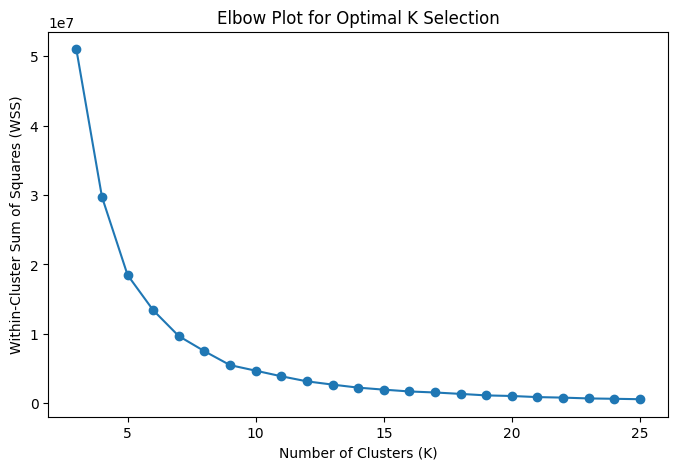

In [ ]:
# Evaluating clustering performance on varying K values
determine_optimal_k(combined_df, max_k = 25)

In [217]:
# Setting a K of 18 and placing players into relative value tiers
final_df = segment_players(combined_df, k = 18)

In [218]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

In [219]:
display(final_df)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank,position_group,relative_value,final_ranking,position_rank,player_value_tier
83,19755.0,Shohei Ohtani,29.0,LAD,OF,1604.961304,1737.0,1644.572900,1.0,OF,4556.627027,1.0,1.0,1
10,25764.0,Bobby Witt Jr.,24.0,KC,SS,1474.433838,1604.0,1513.303638,2.0,IF,4001.305370,2.0,1.0,2
101,15640.0,Aaron Judge,32.0,NYY,OF,1490.744629,1712.0,1557.121240,1.0,OF,3708.297913,3.0,2.0,3
48,13510.0,Jose Ramirez,31.0,CLE,3B,1462.773438,1514.0,1478.141406,3.0,IF,3607.438722,4.0,1.0,3
138,20123.0,Juan Soto,25.0,NYM,OF,1485.821655,1623.0,1526.975195,2.0,OF,3431.641936,5.0,3.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,24262.0,Ceddanne Rafaela,23.0,BOS,2B,816.478027,816.0,816.334607,97.0,IF,-1135.390586,284.0,23.0,18
80,16442.0,Ryan O'Hearn,30.0,BAL,1B,827.286743,778.0,812.500708,98.0,IF,-1148.092016,285.0,27.0,18
86,22514.0,Triston Casas,24.0,BOS,1B,644.122375,1192.0,808.485651,99.0,IF,-1161.211168,286.0,28.0,18
3,22581.0,Alejandro Kirk,25.0,TOR,C,838.857849,735.0,807.700500,100.0,IF,-1163.754818,287.0,12.0,18


In [ ]:
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}.csv', index=False)